In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score

# =========================
# 1. 读数据
# =========================
try:
    df = pd.read_csv("2024_Wimbledon_featured_matches.csv")
except:
    df = pd.read_csv("Wimbledon_featured_matches.csv")

# =========================
# 2. 目标变量
# =========================
# 假设 point_victor: 1 = P1 赢分, 2 = P2 赢分
df = df[df["point_victor"].isin([1, 2])]
df["y"] = (df["point_victor"] == 1).astype(int)

# =========================
# 3. 构造"无记忆"特征
# =========================
# 构造缺失的特征
df["is_break_point"] = ((df["p1_break_pt"] > 0) | (df["p2_break_pt"] > 0)).astype(int)
df["is_tiebreak"] = (
    (df["p1_games"] >= 6)
    & (df["p2_games"] >= 6)
    & (df["p1_games"].sub(df["p2_games"]).abs() <= 1)
).astype(int)
df["is_deuce"] = ((df["p1_score"] == "D") | (df["p2_score"] == "D")).astype(int)

# 计算上一分的持续时间
df["elapsed_seconds"] = pd.to_timedelta(df["elapsed_time"]).dt.total_seconds()
df["point_duration"] = df.groupby("match_id")["elapsed_seconds"].diff()
df["prev_point_duration"] = df.groupby("match_id")["point_duration"].shift(1)

# 编码分类变量
le_serve_width = LabelEncoder()
le_serve_depth = LabelEncoder()
le_return_depth = LabelEncoder()

df["serve_width_encoded"] = le_serve_width.fit_transform(df["serve_width"].astype(str))
df["serve_depth_encoded"] = le_serve_depth.fit_transform(df["serve_depth"].astype(str))
df["return_depth_encoded"] = le_return_depth.fit_transform(df["return_depth"].astype(str))

# 获取上一分的特征值（t-1）
df["prev_p1_distance_run"] = df.groupby("match_id")["p1_distance_run"].shift(1)
df["prev_p2_distance_run"] = df.groupby("match_id")["p2_distance_run"].shift(1)
df["prev_rally_count"] = df.groupby("match_id")["rally_count"].shift(1)
df["prev_speed_mph"] = df.groupby("match_id")["speed_mph"].shift(1)
df["prev_serve_width_encoded"] = df.groupby("match_id")["serve_width_encoded"].shift(1)
df["prev_serve_depth_encoded"] = df.groupby("match_id")["serve_depth_encoded"].shift(1)
df["prev_return_depth_encoded"] = df.groupby("match_id")["return_depth_encoded"].shift(1)

feature_cols = [
    # 发球
    "server",
    "serve_no",

    # 比分 / 阶段
    "set_no",
    "game_no",
    "point_no",
    "p1_games",
    "p2_games",
    "p1_sets",
    "p2_sets",

    # 关键分
    "is_break_point",
    "is_tiebreak",
    "is_deuce",
    
    # 上一分的持续时间
    "prev_point_duration",
    
    # 上一分的特征（t-1）
    "prev_p1_distance_run",
    "prev_p2_distance_run",
    "prev_rally_count",
    "prev_speed_mph",
    "prev_serve_width_encoded",
    "prev_serve_depth_encoded",
    "prev_return_depth_encoded"
 ]

X = df[feature_cols].copy()
y = df["y"].values

# 缺失值简单处理（baseline）
X = X.fillna(0)

# =========================
# 4. 训练 / 测试切分
#    （注意：这里是"非时序 baseline"，
#     所以允许随机切分）
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


X_train.shape

(5098, 20)

In [11]:
# =========================
# 5. LASSO Logistic 回归
# =========================
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",   # 或 saga
        C=0.05,                # 正则强度，可交叉验证
        max_iter=2000
    ))
])

pipe.fit(X_train, y_train)

# =========================
# 6. 评估
# =========================
proba_test = pipe.predict_proba(X_test)[:, 1]

print("Log loss :", log_loss(y_test, proba_test))
print("Brier    :", brier_score_loss(y_test, proba_test))
print("ROC AUC  :", roc_auc_score(y_test, proba_test))

# =========================
# 7. LASSO 选出来的特征
# =========================
coef = pipe.named_steps["clf"].coef_.flatten()
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coef
}).sort_values("coef", key=np.abs, ascending=False)

print(coef_df)

Log loss : 0.6432881025739222
Brier    : 0.2210972125464536
ROC AUC  : 0.6814355446580479
                      feature      coef
0                      server -0.728514
6                    p2_games -0.073612
7                     p1_sets  0.069106
5                    p1_games  0.067329
12        prev_point_duration -0.047121
10                is_tiebreak -0.023531
16             prev_speed_mph  0.019189
19  prev_return_depth_encoded -0.019165
13       prev_p1_distance_run  0.006832
3                     game_no  0.000000
1                    serve_no  0.000000
2                      set_no  0.000000
11                   is_deuce  0.000000
9              is_break_point  0.000000
8                     p2_sets  0.000000
4                    point_no  0.000000
15           prev_rally_count  0.000000
14       prev_p2_distance_run  0.000000
17   prev_serve_width_encoded  0.000000
18   prev_serve_depth_encoded  0.000000


d:\Anaconda\envs\mcm\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
d:\Anaconda\envs\mcm\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


In [12]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
proba_test = clf.predict_proba(X_test)[:, 1]
# output roc_auc_score and feature importance
roc_auc = roc_auc_score(y_test, proba_test)
feature_importances = clf.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": feature_importances
}).sort_values("importance", ascending=False)
print("ROC AUC  :", roc_auc)
print(importance_df)

ROC AUC  : 0.7054745176749886
                      feature  importance
0                      server    0.113223
14       prev_p2_distance_run    0.109447
13       prev_p1_distance_run    0.109183
4                    point_no    0.101670
12        prev_point_duration    0.101123
16             prev_speed_mph    0.092422
3                     game_no    0.049483
15           prev_rally_count    0.046079
1                    serve_no    0.043066
17   prev_serve_width_encoded    0.041929
5                    p1_games    0.038208
6                    p2_games    0.037426
19  prev_return_depth_encoded    0.024284
2                      set_no    0.024078
8                     p2_sets    0.020305
7                     p1_sets    0.019179
18   prev_serve_depth_encoded    0.017587
9              is_break_point    0.008836
10                is_tiebreak    0.002471
11                   is_deuce    0.000000


In [13]:
# =========================
# 8. LASSO - 使用 H:AM 列范围 + 之前的特征（所有特征）
# =========================
# H:AM 对应的列（从p1_sets到p2_break_pt_missed）
feature_cols_h_am = [
    "server", "serve_no",  # N, O
    "p1_break_pt", "p2_break_pt",  # AH, AI
    # 之前的特征
    "is_break_point", "is_tiebreak", "is_deuce",
    "set_no", "game_no", "point_no",
    # 上一分的持续时间
    "prev_point_duration",
    # 上一分的特征（t-1）
    "prev_p1_distance_run",
    "prev_p2_distance_run",
    "prev_rally_count",
    "prev_speed_mph",
    "prev_serve_width_encoded",
    "prev_serve_depth_encoded",
    "prev_return_depth_encoded"
]

# 准备数据
X_combined = df[feature_cols_h_am].copy()

# 填充缺失值
X_combined = X_combined.fillna(0)

# 分割数据
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, y, test_size=0.3, random_state=42
)

# 构建LASSO模型
pipe_combined = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=0.1,
        max_iter=2000
    ))
])

pipe_combined.fit(X_train_combined, y_train_combined)

# 评估
proba_test_combined = pipe_combined.predict_proba(X_test_combined)[:, 1]

print("="*50)
print("完整特征集 LASSO 模型结果")
print("="*50)
print("Log loss :", log_loss(y_test_combined, proba_test_combined))
print("Brier    :", brier_score_loss(y_test_combined, proba_test_combined))
print("ROC AUC  :", roc_auc_score(y_test_combined, proba_test_combined))

# 特征重要性
coef_combined = pipe_combined.named_steps["clf"].coef_.flatten()
coef_df_combined = pd.DataFrame({
    "feature": feature_cols_h_am,
    "coef": coef_combined
}).sort_values("coef", key=np.abs, ascending=False)

print("\n特征系数（按绝对值排序）：")
print(coef_df_combined)


完整特征集 LASSO 模型结果
Log loss : 0.6482327535682909
Brier    : 0.22123161449012152
ROC AUC  : 0.6768365879259375

特征系数（按绝对值排序）：
                      feature      coef
0                      server -0.723306
10        prev_point_duration -0.068429
5                 is_tiebreak -0.038652
7                      set_no  0.037751
14             prev_speed_mph  0.029704
9                    point_no  0.026734
17  prev_return_depth_encoded -0.026371
11       prev_p1_distance_run  0.011250
3                 p2_break_pt  0.006378
15   prev_serve_width_encoded -0.002083
1                    serve_no  0.001061
6                    is_deuce  0.000000
2                 p1_break_pt  0.000000
4              is_break_point  0.000000
8                     game_no  0.000000
12       prev_p2_distance_run  0.000000
13           prev_rally_count  0.000000
16   prev_serve_depth_encoded  0.000000


d:\Anaconda\envs\mcm\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
d:\Anaconda\envs\mcm\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


In [14]:
# =========================
# 9. 动量-残差 ARX（惯性 + 外生输入）
# 修正：对 u_prev 特征先填充缺失，确保 M_t 不被 NaN 传播；按比赛内顺序递推
# =========================
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1) 逻辑回归在全样本的残差 r_t = y_t - p_hat_t
proba_all = pipe.predict_proba(X)[:, 1]
df["resid"] = y - proba_all

# 2) 构造 ARX 输入：r_{t-1} 与 u_{t-1}
u_prev_cols = [
    "prev_point_duration",
    "prev_p1_distance_run",
    "prev_p2_distance_run",
    "prev_rally_count",
    "prev_speed_mph",
    "prev_serve_width_encoded",
    "prev_serve_depth_encoded",
    "prev_return_depth_encoded",
 ]

# 关键修正：先处理缺失（首分的 prev_* 等结构性缺失全部置 0）
df[u_prev_cols] = df[u_prev_cols].fillna(0)

# 按比赛内顺序排序，避免乱序导致递推不一致
df_sorted = df.sort_values(["match_id", "set_no", "game_no", "point_no", "elapsed_seconds"], kind="mergesort")

df_sorted["resid_prev"] = df_sorted.groupby("match_id")["resid"].shift(1)

use_cols = ["resid", "resid_prev"] + u_prev_cols
arx_df = df_sorted[use_cols].copy().dropna()

Z = arx_df[["resid_prev"] + u_prev_cols].values
r = arx_df["resid"].values

# 3) 拟合线性 ARX：r_t = φ r_{t-1} + γ^T u_{t-1} + e_t
arx = LinearRegression()
arx.fit(Z, r)

r_hat = arx.predict(Z)
rmse = mean_squared_error(r, r_hat)
r2 = r2_score(r, r_hat)

print("="*50)
print("动量-残差 ARX 拟合结果（填补 NaN 后）")
print("="*50)
print("RMSE(resid):", rmse)
print("R^2(resid) :", r2)

coef_names = ["phi(resid_prev)"] + [f"gamma({c})" for c in u_prev_cols]
coef_vals = np.concatenate(([arx.coef_[0]], arx.coef_[1:]))
for name, val in zip(coef_names, coef_vals):
    print(f"{name:>24} : {val:+.6f}")
print(f"截距(intercept)     : {arx.intercept_:+.6f}")

# 4) 用 r_hat 调整逻辑概率：p_adj = clip(p_hat + r_hat)
idx = arx_df.index
p_base_series = pd.Series(proba_all, index=df.index)
y_series = pd.Series(y, index=df.index)
p_base_sub = p_base_series.loc[idx].values
p_adj_sub = np.clip(p_base_sub + r_hat, 1e-6, 1 - 1e-6)
y_sub = y_series.loc[idx].values

print("\n" + "-"*50)
print("在ARX可用样本上的评估（基线 vs 动量修正）")
print("-"*50)
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
print("Baseline  LogLoss:", log_loss(y_sub, p_base_sub))
print("Momentum  LogLoss:", log_loss(y_sub, p_adj_sub))
print("Baseline  Brier  :", brier_score_loss(y_sub, p_base_sub))
print("Momentum  Brier  :", brier_score_loss(y_sub, p_adj_sub))
print("Baseline  ROC AUC:", roc_auc_score(y_sub, p_base_sub))
print("Momentum  ROC AUC:", roc_auc_score(y_sub, p_adj_sub))

# 5) 按比赛顺序递推动量 M_t（避免 NaN 传染）
Mt = pd.Series(np.nan, index=df_sorted.index, dtype=float)
phi = arx.coef_[0]
gamma = arx.coef_[1:]

for mid, g in df_sorted.groupby("match_id"):
    prev_idx = None
    for idx_i in g.index:
        if prev_idx is None:
            Mt.loc[idx_i] = 0.0
        else:
            u_prev = df_sorted.loc[idx_i, u_prev_cols].values.astype(float)
            Mt.loc[idx_i] = phi * Mt.loc[prev_idx] + gamma.dot(u_prev)
        prev_idx = idx_i

print("\n动量 M_t 概要（NaN 已填补）：")
print(Mt.describe())

动量-残差 ARX 拟合结果（填补 NaN 后）
RMSE(resid): 0.2187464944019117
R^2(resid) : 0.0020489959499262467
         phi(resid_prev) : +0.023991
gamma(prev_point_duration) : +0.000011
gamma(prev_p1_distance_run) : +0.000965
gamma(prev_p2_distance_run) : -0.002005
 gamma(prev_rally_count) : +0.004995
   gamma(prev_speed_mph) : +0.000015
gamma(prev_serve_width_encoded) : -0.005135
gamma(prev_serve_depth_encoded) : -0.007578
gamma(prev_return_depth_encoded) : -0.000184
截距(intercept)     : +0.021585

--------------------------------------------------
在ARX可用样本上的评估（基线 vs 动量修正）
--------------------------------------------------
Baseline  LogLoss: 0.6328916010891766
Momentum  LogLoss: 0.6290006019512235
Baseline  Brier  : 0.2192499953238119
Momentum  Brier  : 0.2187464944019117
Baseline  ROC AUC: 0.6893345066629666
Momentum  ROC AUC: 0.6937300806298978

动量 M_t 概要（NaN 已填补）：
count    7284.000000
mean       -0.014667
std         0.017972
min        -0.201893
25%        -0.020674
50%        -0.014935
75%        -

In [15]:
# =========================
# 10. 贝叶斯残差模型（Pyro）
# 修正：排序+分组递推，u_prev 标准化，小尺度先验，稳定学习率
# =========================
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from sklearn.preprocessing import StandardScaler

# 基础残差
proba_all = pipe.predict_proba(X)[:, 1]
df["resid"] = y - proba_all

u_prev_cols = [
    "prev_point_duration",
    "prev_p1_distance_run",
    "prev_p2_distance_run",
    "prev_rally_count",
    "prev_speed_mph",
    "prev_serve_width_encoded",
    "prev_serve_depth_encoded",
    "prev_return_depth_encoded",
]

# 1) 排序 + shift，且先填补 prev_* 缺失
a = df.sort_values(["match_id", "set_no", "game_no", "point_no", "elapsed_seconds"], kind="mergesort").copy()
a[u_prev_cols] = a[u_prev_cols].fillna(0)
a["resid_prev"] = a.groupby("match_id")["resid"].shift(1)

# 2) 构造用于 Pyro 的表，保留 match_id 以便分组递推
b = a[["match_id", "resid", "resid_prev"] + u_prev_cols].dropna(subset=["resid_prev"])

# 3) 标准化 u_prev（避免尺度失配导致 sigma 爆炸）；resid 本身在 [-1,1]，无需缩放
sc_U = StandardScaler()
U_prev_std = sc_U.fit_transform(b[u_prev_cols].values.astype(float))

r_t = torch.tensor(b["resid"].values, dtype=torch.float32)
r_prev = torch.tensor(b["resid_prev"].values, dtype=torch.float32)
U_prev = torch.tensor(U_prev_std, dtype=torch.float32)

# 模型：r_t ~ Normal(phi * r_{t-1} + gamma^T u_{t-1}, sigma)
def model(r_prev, U_prev, r_t):
    phi = pyro.sample("phi", dist.Normal(0.0, 1.0))
    gamma = pyro.sample("gamma", dist.Normal(torch.zeros(U_prev.shape[1]), torch.ones(U_prev.shape[1])).to_event(1))
    sigma = pyro.sample("sigma", dist.HalfNormal(0.5))  # 更小的先验尺度
    mu = phi * r_prev + (U_prev @ gamma)
    with pyro.plate("data", len(r_t)):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=r_t)

# 引导：对 sigma 用 LogNormal 形式更稳定
def guide(r_prev, U_prev, r_t):
    phi_loc = pyro.param("phi_loc", torch.tensor(0.0))
    phi_scale = pyro.param("phi_scale", torch.tensor(0.1), constraint=dist.constraints.positive)
    gamma_loc = pyro.param("gamma_loc", torch.zeros(U_prev.shape[1]))
    gamma_scale = pyro.param("gamma_scale", torch.ones(U_prev.shape[1]) * 0.1, constraint=dist.constraints.positive)
    sigma_loc = pyro.param("sigma_loc", torch.tensor(-1.0))
    sigma_scale = pyro.param("sigma_scale", torch.tensor(0.2), constraint=dist.constraints.positive)
    pyro.sample("phi", dist.Normal(phi_loc, phi_scale))
    pyro.sample("gamma", dist.Normal(gamma_loc, gamma_scale).to_event(1))
    pyro.sample("sigma", dist.LogNormal(sigma_loc, sigma_scale))

pyro.clear_param_store()
optimizer = ClippedAdam({"lr": 0.005})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

for step in range(4000):
    loss = svi.step(r_prev, U_prev, r_t)
    if step % 500 == 0:
        print(f"step {step}, ELBO: {loss:.4f}")

phi_est = pyro.param("phi_loc").item()
gamma_est = pyro.param("gamma_loc").detach().numpy()
sigma_med = float(torch.exp(pyro.param("sigma_loc")))  # LogNormal 的中位数
print("\n贝叶斯残差参数（均值场近似）：")
print("phi        :", phi_est)
print("gamma mean :", gamma_est)
print("sigma med  :", sigma_med)

# 4) 按比赛分组递推动量 M_t（使用标准化后的 u_prev）
phi = float(phi_est)
gamma = gamma_est.astype(float)
U_std_df = pd.DataFrame(U_prev_std, index=b.index, columns=u_prev_cols)
Mt_sub = np.zeros(len(b), dtype=float)
pos_map = {idx: i for i, idx in enumerate(b.index)}

for mid, g in b.groupby("match_id", sort=False):
    idxs = g.index.to_list()
    for j, idx_row in enumerate(idxs):
        pos = pos_map[idx_row]
        if j == 0:
            Mt_sub[pos] = 0.0
        else:
            u_vec = U_std_df.loc[idx_row].values.astype(float)
            prev_pos = pos_map[idxs[j - 1]]
            Mt_sub[pos] = phi * Mt_sub[prev_pos] + gamma.dot(u_vec)

alpha = 1.0
p_base_series = pd.Series(proba_all, index=df.index)
y_series = pd.Series(y, index=df.index)
p_base_sub = p_base_series.loc[b.index].values
y_sub = y_series.loc[b.index].values

logit_base_sub = np.log(p_base_sub / (1.0 - p_base_sub))
logit_adj_sub = logit_base_sub + alpha * Mt_sub
p_adj_sub = 1.0 / (1.0 + np.exp(-logit_adj_sub))

from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
print("\n评估（基线 vs 贝叶斯动量 logit 修正）")
print("Baseline  LogLoss:", log_loss(y_sub, p_base_sub))
print("Momentum  LogLoss:", log_loss(y_sub, p_adj_sub))
print("Baseline  Brier  :", brier_score_loss(y_sub, p_base_sub))
print("Momentum  Brier  :", brier_score_loss(y_sub, p_adj_sub))
print("Baseline  ROC AUC:", roc_auc_score(y_sub, p_base_sub))
print("Momentum  ROC AUC:", roc_auc_score(y_sub, p_adj_sub))

d:\Anaconda\envs\mcm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


step 0, ELBO: 8336.3469
step 500, ELBO: 4995.6328
step 1000, ELBO: 4940.3890
step 1500, ELBO: 4840.2432
step 2000, ELBO: 4837.2179
step 2500, ELBO: 4838.3870
step 3000, ELBO: 4831.1390
step 3500, ELBO: 4834.2201

贝叶斯残差参数（均值场近似）：
phi        : 0.03176077827811241
gamma mean : [ 0.01287085  0.00433727 -0.0282727   0.01664662 -0.00712932 -0.00553249
 -0.00577799 -0.00466408]
sigma med  : 0.4696403741836548

评估（基线 vs 贝叶斯动量 logit 修正）
Baseline  LogLoss: 0.6328916010891766
Momentum  LogLoss: 0.6326174787107414
Baseline  Brier  : 0.2192499953238119
Momentum  Brier  : 0.2191953414840042
Baseline  ROC AUC: 0.6893345066629666
Momentum  ROC AUC: 0.6899594355359433


C:\Users\kingg\AppData\Local\Temp\ipykernel_11776\2778163475.py:75: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  sigma_med = float(torch.exp(pyro.param("sigma_loc")))  # LogNormal 的中位数


In [16]:
# =========================
# 11. 实验A：控制基线（无 prev_*） + 残差动量 sanity check
# 目的：把短期记忆从 baseline 拿掉，看残差是否更可预测
# =========================
from sklearn.model_selection import GroupShuffleSplit

control_cols = [
    "server", "serve_no",
    "set_no", "game_no", "point_no",
    "p1_games", "p2_games", "p1_sets", "p2_sets",
    "is_break_point", "is_tiebreak", "is_deuce",
 ]

X_ctrl = df[control_cols].copy().fillna(0)
groups = df["match_id"].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X_ctrl, y, groups))

Xc_train, Xc_test = X_ctrl.iloc[train_idx], X_ctrl.iloc[test_idx]
yc_train, yc_test = y[train_idx], y[test_idx]

pipe_ctrl = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000))
])
pipe_ctrl.fit(Xc_train, yc_train)

proba_ctrl_test = pipe_ctrl.predict_proba(Xc_test)[:, 1]
print("\n[控制基线] Group 留出评估")
print("LogLoss:", log_loss(yc_test, proba_ctrl_test))
print("Brier  :", brier_score_loss(yc_test, proba_ctrl_test))
print("ROC AUC:", roc_auc_score(yc_test, proba_ctrl_test))

# 全量 residual 用于动量检验
proba_ctrl_all = pipe_ctrl.predict_proba(X_ctrl)[:, 1]
resid_ctrl = y - proba_ctrl_all

# 用和之前相同的 u_prev_cols 测试残差是否更可预测
df_ctrl = df.copy()
df_ctrl[u_prev_cols] = df_ctrl[u_prev_cols].fillna(0)
df_ctrl["resid_ctrl"] = resid_ctrl
df_ctrl["resid_ctrl_prev"] = df_ctrl.groupby("match_id")["resid_ctrl"].shift(1)

df_ctrl_sorted = df_ctrl.sort_values(["match_id", "set_no", "game_no", "point_no", "elapsed_seconds"], kind="mergesort")
arx_ctrl_df = df_ctrl_sorted[["resid_ctrl", "resid_ctrl_prev"] + u_prev_cols].dropna()

Zc = arx_ctrl_df[["resid_ctrl_prev"] + u_prev_cols].values
rc = arx_ctrl_df["resid_ctrl"].values
arx_ctrl = LinearRegression()
arx_ctrl.fit(Zc, rc)
rh = arx_ctrl.predict(Zc)

print("\n[控制基线] 残差 ARX 结果")
print("RMSE(resid):", mean_squared_error(rc, rh))
print("R^2(resid) :", r2_score(rc, rh))
print("phi(resid_prev):", arx_ctrl.coef_[0])
print("截距:", arx_ctrl.intercept_)


[控制基线] Group 留出评估
LogLoss: 0.6380637215205913
Brier  : 0.22272501307219322
ROC AUC: 0.6684257306235558

[控制基线] 残差 ARX 结果
RMSE(resid): 0.21880958485917723
R^2(resid) : 0.0020291419281776024
phi(resid_prev): 0.024958710549519255
截距: 0.0014382493822841695


d:\Anaconda\envs\mcm\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [17]:
# =========================
# 12. 实验B：事件驱动的 u_prev（ace/DF/winner/UE/break miss），检验是否带来更强动量
# =========================
candidate_events = [
    "p1_ace", "p2_ace",
    "p1_double_fault", "p2_double_fault",
    "p1_winner", "p2_winner",
    "p1_unf_err", "p2_unf_err",
    "p1_break_pt_missed", "p2_break_pt_missed",
    "p1_break_pt_won", "p2_break_pt_won",
]

event_cols = [c for c in candidate_events if c in df.columns]
if not event_cols:
    print("未找到事件类列，跳过实验B")
else:
    df_ev = df.copy()
    # 为事件列构造上一分特征
    for c in event_cols:
        df_ev[f"prev_{c}"] = df_ev.groupby("match_id")[c].shift(1)
    u_prev_events = [f"prev_{c}" for c in event_cols]

    df_ev[u_prev_events] = df_ev[u_prev_events].fillna(0)
    df_ev["resid_base"] = y - pipe.predict_proba(X)[:, 1]
    df_ev["resid_base_prev"] = df_ev.groupby("match_id")["resid_base"].shift(1)

    df_ev_sorted = df_ev.sort_values(["match_id", "set_no", "game_no", "point_no", "elapsed_seconds"], kind="mergesort")
    ev_df = df_ev_sorted[["match_id", "resid_base", "resid_base_prev"] + u_prev_events].dropna(subset=["resid_base_prev"])

    # 标准化事件驱动特征
    sc_ev = StandardScaler()
    Ue = sc_ev.fit_transform(ev_df[u_prev_events].values.astype(float))
    re = ev_df["resid_base"].values
    re_prev = ev_df["resid_base_prev"].values
    Z_evt = np.column_stack([re_prev, Ue])

    arx_ev = LinearRegression()
    arx_ev.fit(Z_evt, re)
    r_hat_ev = arx_ev.predict(Z_evt)

    print("\n[事件驱动动量] 残差 ARX")
    print("RMSE(resid):", mean_squared_error(re, r_hat_ev))
    print("R^2(resid) :", r2_score(re, r_hat_ev))
    print("phi(resid_prev):", arx_ev.coef_[0])
    # 输出最重要的事件驱动系数
    gamma_ev = arx_ev.coef_[1:]
    topk = min(8, len(u_prev_events))
    idx_sorted = np.argsort(-np.abs(gamma_ev))[:topk]
    print("Top事件系数：")
    for i in idx_sorted:
        print(f"{u_prev_events[i]:>24} : {gamma_ev[i]:+0.4f}")


[事件驱动动量] 残差 ARX
RMSE(resid): 0.21864951009467706
R^2(resid) : 0.0024914514372543772
phi(resid_prev): 0.03482893789128753
Top事件系数：
         prev_p2_unf_err : -0.0147
    prev_p1_double_fault : +0.0098
    prev_p2_double_fault : +0.0078
             prev_p2_ace : -0.0075
    prev_p2_break_pt_won : +0.0071
         prev_p1_unf_err : -0.0065
          prev_p2_winner : +0.0051
          prev_p1_winner : +0.0044


In [18]:
# =========================
## 13. DBN：控制基线 + 标量动量 M_t（logit 空间联合训练，整批训练避免先验重复）
## - 约束 rho ∈ (-1,1) 用 tanh
## - ctrl / u 均标准化以匹配先验尺度
## - TraceMeanField_ELBO + 多粒子降方差，学习率双阶段更稳
## - 采样张量直接建在 device，避免反复拷贝
## - CPU 下减少粒子数与总 epoch，开启多线程
# =========================
import os
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO, Predictive
from pyro.optim import ClippedAdam
from sklearn.preprocessing import StandardScaler

# Install pyro-ppl if not already installed
try:
    import pyro
except ImportError:
    !pip install pyro-ppl
    import pyro

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.set_num_threads(max(1, os.cpu_count() - 1))
# torch.set_num_interop_threads(max(1, os.cpu_count() - 1))
print(f"Using device: {device}, torch threads: {torch.get_num_threads()}")

# 控制变量（弱化 baseline）
ctrl_cols = [
    "server", "serve_no",
    "set_no", "game_no", "point_no",
    "p1_games", "p2_games", "p1_sets", "p2_sets",
    "is_break_point", "is_tiebreak", "is_deuce",
]

# 事件驱动 + 体能/发球状态驱动（上一分/窗口）
event_cols = [c for c in [
    "p1_ace", "p2_ace",
    "p1_double_fault", "p2_double_fault",
    "p1_winner", "p2_winner",
    "p1_unf_err", "p2_unf_err",
    "p1_break_pt_missed", "p2_break_pt_missed",
    "p1_break_pt_won", "p2_break_pt_won",
] if c in df.columns]

df_m = df.sort_values(["match_id", "set_no", "game_no", "point_no", "elapsed_seconds"], kind="mergesort").copy()

# 构造上一分事件特征
for c in event_cols:
    df_m[f"prev_{c}"] = df_m.groupby("match_id")[c].shift(1)

# 构造简单 EWMA（疲劳/发球状态），并 shift(1) 防泄漏
def ewm_prev(series, span=5):
    return series.shift(1).ewm(span=span, adjust=False).mean()

df_m["rally_ewm"] = df_m.groupby("match_id")["rally_count"].transform(lambda s: ewm_prev(s, span=6))
df_m["dist_ewm"] = df_m.groupby("match_id")["p1_distance_run"].transform(lambda s: ewm_prev(s, span=6))
df_m["serve_speed_ewm"] = df_m.groupby("match_id")["speed_mph"].transform(lambda s: ewm_prev(s, span=6))

u_cols = []
u_cols += [f"prev_{c}" for c in event_cols]
u_cols += ["rally_ewm", "dist_ewm", "serve_speed_ewm"]

df_m[u_cols] = df_m[u_cols].fillna(0)

# 设计矩阵（ctrl 也做标准化，避免尺度失配导致先验过度收缩）
X_ctrl_raw = df_m[ctrl_cols].fillna(0).values
sc_ctrl = StandardScaler()
X_ctrl = sc_ctrl.fit_transform(X_ctrl_raw)

U_drv = df_m[u_cols].values
sc_u = StandardScaler()
U_std = sc_u.fit_transform(U_drv)

y_arr = df_m["y"].values.astype(float)

# match_id 编码为整数
match_codes, match_uniques = pd.factorize(df_m["match_id"], sort=False)

ctrl_tensor = torch.tensor(X_ctrl, dtype=torch.float32).to(device)
u_tensor = torch.tensor(U_std, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_arr, dtype=torch.float32).to(device)
match_tensor = torch.tensor(match_codes, dtype=torch.long).to(device)

pyro.clear_param_store()

def dbn_model(ctrl, u, match_ids, y):
    T, p = ctrl.shape
    q = u.shape[1]

    beta = pyro.sample(
        "beta",
        dist.Normal(
            torch.zeros(p, device=device),
            torch.ones(p, device=device),
        ).to_event(1),
    )
    rho_raw = pyro.sample(
        "rho_raw",
        dist.Normal(torch.tensor(0.0, device=device), torch.tensor(0.5, device=device)),
    )
    rho = torch.tanh(rho_raw)

    eta = pyro.sample(
        "eta",
        dist.Normal(
            torch.zeros(q, device=device),
            torch.ones(q, device=device),
        ).to_event(1),
    )

    logits = []
    M_prev = torch.zeros((), device=device)
    last_mid = match_ids[0] if T > 0 else torch.tensor(-1, device=device)

    for t in range(T):
        if match_ids[t] != last_mid:
            M_prev = torch.zeros((), device=device)
            last_mid = match_ids[t]
        M_prev = rho * M_prev + (u[t] @ eta)
        logit_t = (ctrl[t] @ beta) + M_prev
        pyro.sample(f"y_{t}", dist.Bernoulli(logits=logit_t), obs=y[t])
        logits.append(logit_t)
    return torch.stack(logits) if logits else torch.tensor([], device=device)

guide = pyro.infer.autoguide.AutoNormal(dbn_model, init_scale=0.05)
elbo = TraceMeanField_ELBO(num_particles=1)  # CPU 加速：粒子数降到 3
optimizer = ClippedAdam({"lr": 5e-3, "clip_norm": 5.0})
svi = SVI(dbn_model, guide, optimizer, loss=elbo)

# 整批训练，避免先验在 mini-batch 下被重复放大；150 epoch 后小幅降 lr
n_epochs = 500
loss_history = []
for epoch in range(n_epochs):
    if epoch == 150:
        for opt in optimizer.optim_objs.values():
            for pg in opt.param_groups:
                pg["lr"] = 1e-3
    loss = svi.step(ctrl_tensor, u_tensor, match_tensor, y_tensor)
    loss_per_pt = loss / len(df_m)
    loss_history.append(loss_per_pt)
    if (epoch + 1) % 10 == 0:
        print(f"epoch {epoch+1}/{n_epochs} ELBO per-pt: {loss_per_pt:.4f}")

Using device: cpu, torch threads: 8
epoch 10/500 ELBO per-pt: 0.7049
epoch 20/500 ELBO per-pt: 0.6881
epoch 30/500 ELBO per-pt: 0.6898
epoch 40/500 ELBO per-pt: 0.6767
epoch 50/500 ELBO per-pt: 0.6737
epoch 60/500 ELBO per-pt: 0.6566
epoch 70/500 ELBO per-pt: 0.6531
epoch 80/500 ELBO per-pt: 0.6552
epoch 90/500 ELBO per-pt: 0.6508
epoch 100/500 ELBO per-pt: 0.6499
epoch 110/500 ELBO per-pt: 0.6443
epoch 120/500 ELBO per-pt: 0.6438
epoch 130/500 ELBO per-pt: 0.6456
epoch 140/500 ELBO per-pt: 0.6429
epoch 150/500 ELBO per-pt: 0.6425
epoch 160/500 ELBO per-pt: 0.6466
epoch 170/500 ELBO per-pt: 0.6437
epoch 180/500 ELBO per-pt: 0.6431
epoch 190/500 ELBO per-pt: 0.6428
epoch 200/500 ELBO per-pt: 0.6436
epoch 210/500 ELBO per-pt: 0.6437
epoch 220/500 ELBO per-pt: 0.6417
epoch 230/500 ELBO per-pt: 0.6441
epoch 240/500 ELBO per-pt: 0.6434
epoch 250/500 ELBO per-pt: 0.6423
epoch 260/500 ELBO per-pt: 0.6434
epoch 270/500 ELBO per-pt: 0.6442
epoch 280/500 ELBO per-pt: 0.6455
epoch 290/500 ELBO pe

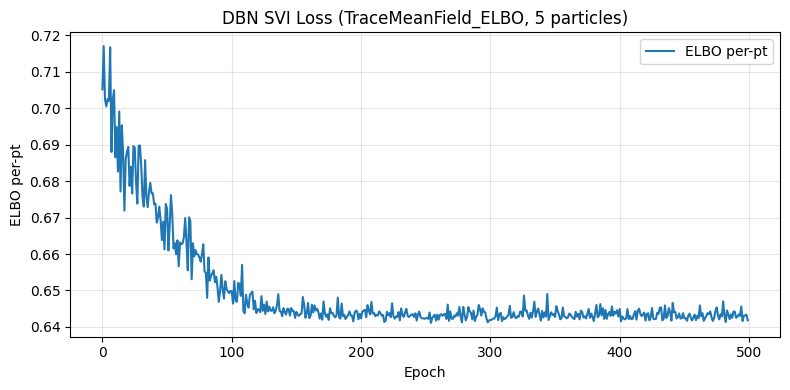

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="ELBO per-pt", color="tab:blue")
plt.xlabel("Epoch")
plt.ylabel("ELBO per-pt")
plt.title("DBN SVI Loss (TraceMeanField_ELBO, 5 particles)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# 取 posterior 平均的 logits 进行评估（改用 Predictive 抽 posterior 参数，再手工递推 logits，避免 _RETURN None）
from pyro.distributions import constraints
from pyro.distributions.transforms import biject_to

num_mc = 20
posterior = Predictive(guide, num_samples=num_mc, return_sites=["beta", "eta", "rho_raw"])(ctrl_tensor, u_tensor, match_tensor, y_tensor)
betas = posterior["beta"]  # [S, p]
etas = posterior["eta"]    # [S, q]
rho_raws = posterior["rho_raw"]  # [S]

logit_samples = []
T = ctrl_tensor.shape[0]
for s in range(num_mc):
    beta_s = betas[s]
    eta_s = etas[s]
    rho_s = torch.tanh(rho_raws[s])
    M_prev = torch.zeros((), device=device)
    last_mid = match_tensor[0] if T > 0 else torch.tensor(-1, device=device)
    logits = []
    for t in range(T):
        if match_tensor[t] != last_mid:
            M_prev = torch.zeros((), device=device)
            last_mid = match_tensor[t]
        M_prev = rho_s * M_prev + (u_tensor[t] @ eta_s)
        logit_t = (ctrl_tensor[t] @ beta_s) + M_prev
        logits.append(logit_t)
    logit_samples.append(torch.stack(logits))

logits_mc = torch.stack(logit_samples)  # [S, T]
p_mc = torch.sigmoid(logits_mc)
p_mean = p_mc.mean(0).detach().cpu().numpy()
y_np = y_tensor.cpu().numpy()

print("\n[DBN 动量] 全量评估 (提醒：当前未做 match 留出)")
print("LogLoss:", log_loss(y_np, p_mean))
print("Brier  :", brier_score_loss(y_np, p_mean))
print("ROC AUC:", roc_auc_score(y_np, p_mean))

# 用后验均值参数递推一个确定性的 M_t 均值，避免逐点采样导致内存溢出
rho_raw_loc = pyro.param("AutoNormal.locs.rho_raw")
rho = float(torch.tanh(rho_raw_loc))
eta = biject_to(constraints.real)(pyro.param("AutoNormal.locs.eta")).detach().cpu().numpy()
Mt_det = np.zeros(len(df_m), dtype=float)
last_mid = match_codes[0] if len(match_codes) > 0 else -1

for i in range(len(df_m)):
    if match_codes[i] != last_mid:
        Mt_det[i] = 0.0
        last_mid = match_codes[i]
    else:
        Mt_det[i] = rho * Mt_det[i-1] + eta.dot(U_std[i])

df_m["Mt_mean"] = Mt_det
print("\n动量 M_t 概要（确定性均值递推）：")
print(df_m["Mt_mean"].describe())
print("提示：如需严格评估，请先按 match_id 过滤训练/验证，再各自跑一遍 SVI 与预测。")


[DBN 动量] 全量评估 (提醒：当前未做 match 留出)
LogLoss: 0.6289371384122375
Brier  : 0.21867743134498596
ROC AUC: 0.6927512605604844

动量 M_t 概要（确定性均值递推）：
count    7284.000000
mean        0.000740
std         0.107197
min        -0.391276
25%        -0.080656
50%         0.033025
75%         0.054316
max         0.418178
Name: Mt_mean, dtype: float64
提示：如需严格评估，请先按 match_id 过滤训练/验证，再各自跑一遍 SVI 与预测。


### 6) 可解释输出：flow 曲线、反转风险、因素贡献
- 选定一场比赛，基于后验样本得到动量 $M_t$ 的均值及置信带。
- 计算“过零”概率：$\Pr(M_{t+1} M_t < 0 \mid \mathcal H_t)$。
- 分解动量增量 $\Delta M_t \approx \rho M_{t-1} + \eta^\top u_t$ 的分项贡献，展示哪类事件/疲劳因素在推高或压低动量。

In [23]:
import numpy as np
import pandas as pd

# 选择要解释的一场比赛
target_match = match_uniques[0]  # 可改成其他 match_id
mask = df_m["match_id"] == target_match
seq_idx = np.flatnonzero(mask.values)
assert len(seq_idx) > 1, "所选比赛的样本不足"

# 如当前会话没有 posterior，可重跑上一格；这里复用已有 posterior 抽样
if "posterior" not in locals():
    posterior = Predictive(guide, num_samples=num_mc, return_sites=["beta", "eta", "rho_raw"])(ctrl_tensor, u_tensor, match_tensor, y_tensor)
    betas = posterior["beta"]
    etas = posterior["eta"]
    rho_raws = posterior["rho_raw"]

U_std_np = U_std  # ndarray
M_samples = []
for s in range(rho_raws.shape[0]):
    rho_s = float(torch.tanh(rho_raws[s]))
    eta_s = etas[s].detach().cpu().numpy()
    M_prev = 0.0
    seq = []
    for i in seq_idx:
        M_prev = rho_s * M_prev + float(np.dot(U_std_np[i], eta_s))
        seq.append(M_prev)
    M_samples.append(seq)

M_arr = np.array(M_samples)  # [S, T_match]
M_mean = M_arr.mean(0)
band_lo, band_hi = np.percentile(M_arr, [5, 95], axis=0)  # 90% 区间
swing_prob = (M_arr[:, 1:] * M_arr[:, :-1] < 0).mean(0)

flow_df = pd.DataFrame({
    "match_id": target_match,
    "set_no": df_m.loc[mask, "set_no"].values,
    "game_no": df_m.loc[mask, "game_no"].values,
    "point_no": df_m.loc[mask, "point_no"].values,
    "M_mean": M_mean,
    "M_p05": band_lo,
    "M_p95": band_hi,
})
flow_df["swing_prob_next"] = np.append(swing_prob, np.nan)

print("Flow 曲线（前 10 行）")
print(flow_df.head(10))

# 因素贡献：使用变分均值参数，把 eta^T u_t 分解
eta_mean = biject_to(constraints.real)(pyro.param("AutoNormal.locs.eta")).detach().cpu().numpy()
rho_mean = float(torch.tanh(pyro.param("AutoNormal.locs.rho_raw")))

last_i = seq_idx[-2]  # 取倒数第二个点，对应 swing_prob_next
contrib = eta_mean * U_std_np[last_i]
contrib_df = pd.DataFrame({
    "feature": u_cols,
    "contrib": contrib
}).sort_values("contrib", key=np.abs, ascending=False)

print("\n因素贡献（取倒数第二个点，对应 swing_prob_next）")
print(contrib_df.head(12))
print(f"rho_mean: {rho_mean:+.4f}, M_mean[t-1]: {M_mean[-2]:+.4f}, eta^T u_t: {float(np.dot(eta_mean, U_std_np[last_i])):+.4f}")

Flow 曲线（前 10 行）
              match_id  set_no  game_no  point_no    M_mean     M_p05  \
0  2023-wimbledon-1301       1        1         1 -0.251779 -0.439536   
1  2023-wimbledon-1301       1        1         2 -0.165743 -0.331464   
2  2023-wimbledon-1301       1        1         3  0.019793 -0.069488   
3  2023-wimbledon-1301       1        1         4 -0.168526 -0.327575   
4  2023-wimbledon-1301       1        1         5  0.217122  0.093529   
5  2023-wimbledon-1301       1        1         6  0.042297 -0.249997   
6  2023-wimbledon-1301       1        1         7  0.059867 -0.017960   
7  2023-wimbledon-1301       1        1         8  0.022982 -0.298982   
8  2023-wimbledon-1301       1        1         9  0.051092 -0.029630   
9  2023-wimbledon-1301       1        1        10  0.086576 -0.020235   

      M_p95  swing_prob_next  
0 -0.055986             0.20  
1  0.074444             0.40  
2  0.095967             0.45  
3  0.030949             0.90  
4  0.345142             0

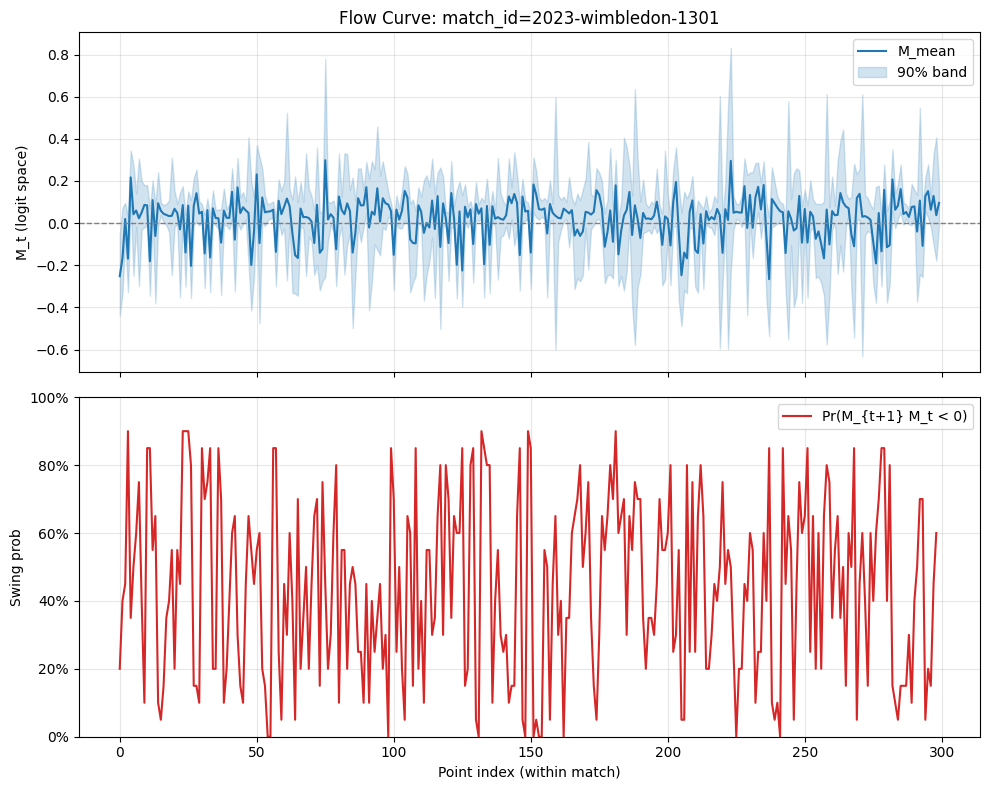

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 依赖上一单元生成的 flow_df、swing_prob、M_arr
assert "flow_df" in locals(), "请先运行上一单元以生成 flow_df"
t_axis = np.arange(len(flow_df))

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# flow 曲线 + 置信带
axes[0].plot(t_axis, flow_df["M_mean"], color="tab:blue", label="M_mean")
axes[0].fill_between(t_axis, flow_df["M_p05"], flow_df["M_p95"], color="tab:blue", alpha=0.2, label="90% band")
axes[0].axhline(0, color="gray", lw=1, ls="--")
axes[0].set_ylabel("M_t (logit space)")
axes[0].set_title(f"Flow Curve: match_id={flow_df['match_id'].iloc[0]}")
axes[0].legend()
axes[0].grid(alpha=0.3)

# 反转风险
axes[1].plot(t_axis[:-1], swing_prob, color="tab:red", label="Pr(M_{t+1} M_t < 0)")
axes[1].set_ylabel("Swing prob")
axes[1].set_xlabel("Point index (within match)")
axes[1].set_ylim(0, 1)
axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

In [25]:
# =========================
## 14. Player-layer momentum data tensors (Layer1+Layer2)
## + Identifiability prep: add intercept (unscaled)
## =========================
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F

# 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 复制排序后的 df_m，保证顺序一致
player_df = df_m.copy()

# -------------------------
# A. 玩家 ID 映射
# -------------------------
all_players = pd.Index(pd.unique(pd.concat([player_df["player1"], player_df["player2"]], ignore_index=True)))
player_lookup = pd.Series(np.arange(len(all_players)), index=all_players)
player_df["p1_id"] = player_df["player1"].map(player_lookup)
player_df["p2_id"] = player_df["player2"].map(player_lookup)
player_df["server_id"] = np.where(player_df["server"] == 1, player_df["p1_id"], player_df["p2_id"])
player_df["receiver_id"] = np.where(player_df["server"] == 1, player_df["p2_id"], player_df["p1_id"])

# match -> (p1,p2) 映射，用于 match 切换时 reset 对应两名球员的动量
match_players = player_df.groupby("match_id")[ ["p1_id", "p2_id"] ].first().reset_index()
match_to_p1 = dict(zip(match_players["match_id"], match_players["p1_id"]))
match_to_p2 = dict(zip(match_players["match_id"], match_players["p2_id"]))
player_df["match_p1_id"] = player_df["match_id"].map(match_to_p1)
player_df["match_p2_id"] = player_df["match_id"].map(match_to_p2)

# match factorize（行级编码 + code -> p1/p2 查表）
match_codes, match_uniques = pd.factorize(player_df["match_id"], sort=False)
n_matches = len(match_uniques)
match_p1_by_code = np.zeros(n_matches, dtype=np.int64)
match_p2_by_code = np.zeros(n_matches, dtype=np.int64)
for code, mid in enumerate(match_uniques):
    match_p1_by_code[code] = match_to_p1[mid]
    match_p2_by_code[code] = match_to_p2[mid]

# -------------------------
# B. 事件与疲劳特征（全部 t-1）
# -------------------------
event_bases = [
    "ace",
    "double_fault",
    "winner",
    "unf_err",
    "break_pt_won",
    "break_pt_missed",
 ]
available_bases = [b for b in event_bases if f"p1_{b}" in player_df.columns and f"p2_{b}" in player_df.columns]
for b in available_bases:
    player_df[f"p1_{b}_prev"] = player_df.groupby("match_id")[f"p1_{b}"].shift(1)
    player_df[f"p2_{b}_prev"] = player_df.groupby("match_id")[f"p2_{b}"].shift(1)
    player_df[f"server_prev_{b}"] = np.where(player_df["server"] == 1, player_df[f"p1_{b}_prev"], player_df[f"p2_{b}_prev"])
    player_df[f"receiver_prev_{b}"] = np.where(player_df["server"] == 1, player_df[f"p2_{b}_prev"], player_df[f"p1_{b}_prev"])

# rally 上一分
player_df["rally_prev"] = player_df.groupby("match_id")["rally_count"].shift(1)

# 疲劳（跑动 EWMA, span=6，先 shift 再 ewm）
def ewm_prev(series, span=6):
    return series.shift(1).ewm(span=span, adjust=False).mean()

player_df["dist_ewm_p1"] = player_df.groupby("match_id")["p1_distance_run"].transform(lambda s: ewm_prev(s, span=6))
player_df["dist_ewm_p2"] = player_df.groupby("match_id")["p2_distance_run"].transform(lambda s: ewm_prev(s, span=6))
player_df["server_dist_ewm"] = np.where(player_df["server"] == 1, player_df["dist_ewm_p1"], player_df["dist_ewm_p2"])
player_df["receiver_dist_ewm"] = np.where(player_df["server"] == 1, player_df["dist_ewm_p2"], player_df["dist_ewm_p1"])

# 发球速度 EWMA（仅该球员发球分更新），span=6
a = player_df
player_df["speed_on_p1_serve"] = np.where(a["server"] == 1, a["speed_mph"], np.nan)
player_df["speed_on_p2_serve"] = np.where(a["server"] == 2, a["speed_mph"], np.nan)
player_df["serve_speed_ewm_p1"] = player_df.groupby("match_id")["speed_on_p1_serve"].transform(lambda s: ewm_prev(s, span=6)).ffill().fillna(0)
player_df["serve_speed_ewm_p2"] = player_df.groupby("match_id")["speed_on_p2_serve"].transform(lambda s: ewm_prev(s, span=6)).ffill().fillna(0)
player_df["server_serve_speed_ewm"] = np.where(player_df["server"] == 1, player_df["serve_speed_ewm_p1"], player_df["serve_speed_ewm_p2"])
player_df["receiver_serve_speed_ewm"] = np.where(player_df["server"] == 1, player_df["serve_speed_ewm_p2"], player_df["serve_speed_ewm_p1"])

# -------------------------
# C. 设计矩阵 & 标准化
# -------------------------
ctrl_cols_no_intercept = [
    "serve_no",
    "set_no", "game_no", "point_no",
    "p1_games", "p2_games", "p1_sets", "p2_sets",
    "is_break_point", "is_tiebreak", "is_deuce",
 ]

uS_cols = [f"server_prev_{b}" for b in available_bases] + [
    "server_dist_ewm", "server_serve_speed_ewm", "rally_prev",
]
uR_cols = [f"receiver_prev_{b}" for b in available_bases] + [
    "receiver_dist_ewm", "receiver_serve_speed_ewm", "rally_prev",
 ]

# 逐块填充，避免重复列导致赋值出错
player_df[ctrl_cols_no_intercept] = player_df[ctrl_cols_no_intercept].fillna(0)
player_df[uS_cols] = player_df[uS_cols].fillna(0)
player_df[uR_cols] = player_df[uR_cols].fillna(0)
player_df[["server_id", "receiver_id", "match_p1_id", "match_p2_id", "y"]] = player_df[["server_id", "receiver_id", "match_p1_id", "match_p2_id", "y"]].fillna(0)

# ctrl: add intercept (unstandardized) + standardized remainder
X_ctrl_no_intercept = player_df[ctrl_cols_no_intercept].values
sc_ctrl_new = StandardScaler()
ctrl_scaled_no_intercept = sc_ctrl_new.fit_transform(X_ctrl_no_intercept)
intercept_col = np.ones((len(player_df), 1), dtype=float)
ctrl_scaled = np.concatenate([intercept_col, ctrl_scaled_no_intercept], axis=1)

uS_arr = player_df[uS_cols].values
uR_arr = player_df[uR_cols].values

sc_u_new = StandardScaler()
sc_u_new.fit(np.vstack([uS_arr, uR_arr]))
uS_scaled = sc_u_new.transform(uS_arr)
uR_scaled = sc_u_new.transform(uR_arr)

# -------------------------
# D. 张量化
# -------------------------
n_players = len(all_players)
ctrl_tensor = torch.tensor(ctrl_scaled, dtype=torch.float32, device=device)
uS_tensor = torch.tensor(uS_scaled, dtype=torch.float32, device=device)
uR_tensor = torch.tensor(uR_scaled, dtype=torch.float32, device=device)
server_id_tensor = torch.tensor(player_df["server_id"].values, dtype=torch.long, device=device)
receiver_id_tensor = torch.tensor(player_df["receiver_id"].values, dtype=torch.long, device=device)
match_id_tensor = torch.tensor(match_codes, dtype=torch.long, device=device)
match_p1_by_code_tensor = torch.tensor(match_p1_by_code, dtype=torch.long, device=device)
match_p2_by_code_tensor = torch.tensor(match_p2_by_code, dtype=torch.long, device=device)
y_tensor = torch.tensor(player_df["y"].values.astype(float), dtype=torch.float32, device=device)

# 方便解释：id -> 名字
player_id_to_name = pd.Series(all_players, index=np.arange(len(all_players)))

print("ctrl_tensor", tuple(ctrl_tensor.shape), "(with intercept)")
print("uS_tensor", tuple(uS_tensor.shape), "uR_tensor", tuple(uR_tensor.shape))
print("server_id_tensor", tuple(server_id_tensor.shape))
print("match_id_tensor", tuple(match_id_tensor.shape))
print("n_players, n_matches", n_players, n_matches)

ctrl_tensor (7284, 12) (with intercept)
uS_tensor (7284, 9) uR_tensor (7284, 9)
server_id_tensor (7284,)
match_id_tensor (7284,)
n_players, n_matches 32 31


In [29]:
# =========================
# 15. Layer1+Layer2 player DBN (Pyro, full-batch SVI)
# Identifiability Fix + Momentum prior upgrade (rho biased high)
# =========================
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoNormal

pyro.clear_param_store()


def player_dbn_model(ctrl, uS, uR, server_id, receiver_id, match_ids, y, match_p1_by_code, match_p2_by_code, n_players):
    T, p = ctrl.shape
    q = uS.shape[1]

    beta = pyro.sample(
        "beta", dist.Normal(torch.zeros(p, device=device), torch.ones(p, device=device)).to_event(1)
    )
    serve_skill = pyro.sample(
        "serve_skill",
        dist.Normal(torch.zeros(n_players, device=device), torch.ones(n_players, device=device)).to_event(1),
    )
    return_skill = pyro.sample(
        "return_skill",
        dist.Normal(torch.zeros(n_players, device=device), torch.ones(n_players, device=device)).to_event(1),
    )
    # Option A: rho prior biased toward positive/high persistence (atanh(0.7)≈0.8673)
    rho_loc = torch.tensor(0.8673, device=device)
    rho_scale = torch.tensor(0.5, device=device)
    rho_raw = pyro.sample(
        "rho_raw",
        dist.Normal(rho_loc.expand(n_players), rho_scale.expand(n_players)).to_event(1),
    )
    kappa_raw = pyro.sample(
        "kappa_raw",
        dist.Normal(torch.zeros(n_players, device=device), torch.full((n_players,), 0.7, device=device)).to_event(1),
    )
    eta = pyro.sample(
        "eta", dist.Normal(torch.zeros(q, device=device), torch.ones(q, device=device)).to_event(1)
    )

    rho = torch.tanh(rho_raw)
    kappa = F.softplus(kappa_raw)

    # Center skills to avoid pushing global bias into all players
    serve_skill_centered = serve_skill - serve_skill.mean()
    return_skill_centered = return_skill - return_skill.mean()

    m = torch.zeros(n_players, device=device)
    logits = torch.empty(T, device=device)
    last_match = match_ids[0] if T > 0 else torch.tensor(-1, device=device)

    for t in range(T):
        mid = match_ids[t]
        if mid != last_match:
            mp1 = match_p1_by_code[mid]
            mp2 = match_p2_by_code[mid]
            zero_idx = torch.tensor([mp1, mp2], device=device)
            m = m.clone()
            m = m.index_put((zero_idx,), torch.zeros(2, device=device))
            last_match = mid
        s = server_id[t]
        r = receiver_id[t]
        m = m.clone()
        m_s = rho[s] * m[s] + kappa[s] * (uS[t] @ eta)
        m_r = rho[r] * m[r] + kappa[r] * (uR[t] @ eta)
        idx_sr = torch.tensor([s, r], device=device)
        m = m.index_put((idx_sr,), torch.stack([m_s, m_r]))
        net_m = m[s] - m[r]
        base_logit = (ctrl[t] @ beta) + serve_skill_centered[s] - return_skill_centered[r]
        logits[t] = base_logit + net_m

    with pyro.plate("data", T):
        pyro.sample("y", dist.Bernoulli(logits=logits), obs=y)

    return logits


# Guide / ELBO / Optimizer
guide_player = AutoNormal(player_dbn_model, init_scale=0.05)
elbo_player = TraceMeanField_ELBO(num_particles=5)
optimizer_player = ClippedAdam({"lr": 1e-2, "clip_norm": 5.0})
svi_player = SVI(player_dbn_model, guide_player, optimizer_player, loss=elbo_player)

# 训练
n_epochs = 500
smoothed = None
for epoch in range(n_epochs):
    if epoch == 150:
        for opt in optimizer_player.optim_objs.values():
            for pg in opt.param_groups:
                pg["lr"] = 1e-3
    loss = svi_player.step(
        ctrl_tensor,
        uS_tensor,
        uR_tensor,
        server_id_tensor,
        receiver_id_tensor,
        match_id_tensor,
        y_tensor,
        match_p1_by_code_tensor,
        match_p2_by_code_tensor,
        n_players,
    )
    loss_pt = loss / len(player_df)
    smoothed = loss_pt if smoothed is None else 0.98 * smoothed + 0.02 * loss_pt
    if (epoch + 1) % 10 == 0:
        rho_loc_cur = pyro.param("AutoNormal.locs.rho_raw").detach()
        kappa_loc = pyro.param("AutoNormal.locs.kappa_raw").detach()
        rho_vals = torch.tanh(rho_loc_cur).cpu().numpy()
        kappa_vals = F.softplus(kappa_loc).cpu().numpy()
        print(
            f"epoch {epoch+1:4d} smoothed_ELBO_per_pt={smoothed:.4f} "
            f"rho_mean_range=({rho_vals.min():+.3f},{rho_vals.mean():+.3f},{rho_vals.max():+.3f}) "
            f"kappa_mean_range=({kappa_vals.min():+.3f},{kappa_vals.mean():+.3f},{kappa_vals.max():+.3f})"
        )

epoch   10 smoothed_ELBO_per_pt=0.7492 rho_mean_range=(+0.001,+0.093,+0.100) kappa_mean_range=(+0.645,+0.665,+0.735)
epoch   20 smoothed_ELBO_per_pt=0.7426 rho_mean_range=(-0.073,+0.172,+0.200) kappa_mean_range=(+0.597,+0.650,+0.791)
epoch   30 smoothed_ELBO_per_pt=0.7341 rho_mean_range=(-0.059,+0.235,+0.298) kappa_mean_range=(+0.549,+0.637,+0.857)
epoch   40 smoothed_ELBO_per_pt=0.7253 rho_mean_range=(+0.041,+0.284,+0.397) kappa_mean_range=(+0.508,+0.628,+0.923)
epoch   50 smoothed_ELBO_per_pt=0.7167 rho_mean_range=(+0.019,+0.327,+0.480) kappa_mean_range=(+0.478,+0.624,+0.965)
epoch   60 smoothed_ELBO_per_pt=0.7088 rho_mean_range=(+0.034,+0.369,+0.553) kappa_mean_range=(+0.461,+0.621,+0.953)
epoch   70 smoothed_ELBO_per_pt=0.7017 rho_mean_range=(+0.072,+0.407,+0.608) kappa_mean_range=(+0.463,+0.618,+0.930)
epoch   80 smoothed_ELBO_per_pt=0.6953 rho_mean_range=(+0.115,+0.439,+0.644) kappa_mean_range=(+0.470,+0.617,+0.949)
epoch   90 smoothed_ELBO_per_pt=0.6897 rho_mean_range=(+0.085,+0

全量评估（提醒：未做 match 留出重训）
LogLoss: 0.6189072864912059
Brier  : 0.21430747210979462
ROC AUC: 0.7162871911728634

Group 留出（按 match_id）评估：
LogLoss: 0.6151642986373105
Brier  : 0.2126161754131317
ROC AUC: 0.7211348213555718

Flip count: 2438 / T=7284, freq=0.3347


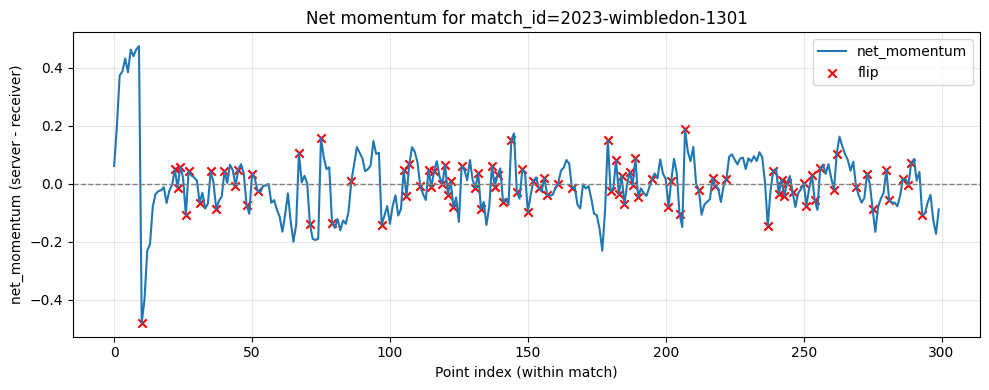


Flip window contributions (top-3 by abs, per side):
flip#1 at t=10:
  server drivers: rally_prev:+0.068, server_serve_speed_ewm:+0.028, server_prev_ace:+0.024
  receiver drivers: receiver_serve_speed_ewm:+0.105, rally_prev:+0.076, receiver_prev_unf_err:+0.011
flip#2 at t=22:
  server drivers: rally_prev:+0.046, server_prev_unf_err:+0.016, server_prev_ace:+0.015
  receiver drivers: rally_prev:+0.048, receiver_prev_unf_err:+0.016, receiver_serve_speed_ewm:+0.007
flip#3 at t=23:
  server drivers: rally_prev:+0.046, server_prev_unf_err:+0.019, server_prev_ace:+0.015
  receiver drivers: rally_prev:+0.049, receiver_prev_unf_err:+0.017, receiver_serve_speed_ewm:+0.007
flip#4 at t=24:
  server drivers: rally_prev:+0.047, server_prev_unf_err:+0.015, server_prev_ace:+0.015
  receiver drivers: rally_prev:+0.051, receiver_prev_unf_err:+0.017, receiver_serve_speed_ewm:+0.008
flip#5 at t=26:
  server drivers: rally_prev:+0.051, server_prev_unf_err:+0.015, server_prev_ace:+0.015
  receiver drivers: 

In [31]:
# =========================
# 16. 可解释输出 + 留出评估（player-layer DBN）
# 升级：net_momentum flip 标记 + flip 驱动贡献
# =========================
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt


def deterministic_forward(ctrl, uS, uR, server_id, receiver_id, match_ids, match_p1_by_code, match_p2_by_code):
    """使用 guide 的后验均值做一次确定性前向，返回 logits 与净动量序列。"""
    beta = pyro.param("AutoNormal.locs.beta").detach()
    eta = pyro.param("AutoNormal.locs.eta").detach()
    rho = torch.tanh(pyro.param("AutoNormal.locs.rho_raw").detach())
    kappa = F.softplus(pyro.param("AutoNormal.locs.kappa_raw").detach())
    serve_skill = pyro.param("AutoNormal.locs.serve_skill").detach()
    return_skill = pyro.param("AutoNormal.locs.return_skill").detach()

    serve_skill_centered = serve_skill - serve_skill.mean()
    return_skill_centered = return_skill - return_skill.mean()

    T = ctrl.shape[0]
    logits = torch.empty(T, device=device)
    net_m_seq = torch.empty(T, device=device)
    m = torch.zeros(n_players, device=device)
    last_match = match_ids[0] if T > 0 else torch.tensor(-1, device=device)

    for t in range(T):
        mid = match_ids[t]
        if mid != last_match:
            mp1 = match_p1_by_code[mid]
            mp2 = match_p2_by_code[mid]
            m = m.clone()
            m[mp1] = 0.0
            m[mp2] = 0.0
            last_match = mid
        s = server_id[t]
        r = receiver_id[t]
        m = m.clone()
        m[s] = rho[s] * m[s] + kappa[s] * (uS[t] @ eta)
        m[r] = rho[r] * m[r] + kappa[r] * (uR[t] @ eta)
        net_m = m[s] - m[r]
        base_logit = (ctrl[t] @ beta) + serve_skill_centered[s] - return_skill_centered[r]
        logits[t] = base_logit + net_m
        net_m_seq[t] = net_m
    return logits, net_m_seq


# 前向预测
det_logits, net_m_seq = deterministic_forward(
    ctrl_tensor,
    uS_tensor,
    uR_tensor,
    server_id_tensor,
    receiver_id_tensor,
    match_id_tensor,
    match_p1_by_code_tensor,
    match_p2_by_code_tensor,
 )
p_det = torch.sigmoid(det_logits).detach().cpu().numpy()
y_np = y_tensor.cpu().numpy()

print("全量评估（提醒：未做 match 留出重训）")
print("LogLoss:", log_loss(y_np, p_det))
print("Brier  :", brier_score_loss(y_np, p_det))
print("ROC AUC:", roc_auc_score(y_np, p_det))

# match 留出评估（仅验证泄漏影响，未重训）
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, test_idx = next(gss.split(np.zeros_like(y_np), y_np, groups=match_codes))
print("\nGroup 留出（按 match_id）评估：")
print("LogLoss:", log_loss(y_np[test_idx], p_det[test_idx]))
print("Brier  :", brier_score_loss(y_np[test_idx], p_det[test_idx]))
print("ROC AUC:", roc_auc_score(y_np[test_idx], p_det[test_idx]))

# flip 点检测
net_m_np = net_m_seq.detach().cpu().numpy()
signs = np.sign(net_m_np)
flip_idx = np.where(signs[1:] * signs[:-1] < 0)[0] + 1  # index where t flips vs t-1
print(f"\nFlip count: {len(flip_idx)} / T={len(net_m_np)}, freq={len(flip_idx)/len(net_m_np):.4f}")

# 选一场比赛绘制 net_momentum 曲线并标记 flip
target_match_code = match_codes[0]
mask_match = match_codes == target_match_code
t_axis = np.arange(mask_match.sum())
net_m_match = net_m_np[mask_match]
flip_in_match = flip_idx[np.isin(flip_idx, np.nonzero(mask_match)[0])]
flip_rel = flip_in_match - np.nonzero(mask_match)[0][0] if len(flip_in_match)>0 else np.array([])

plt.figure(figsize=(10, 4))
plt.plot(t_axis, net_m_match, label="net_momentum")
if len(flip_rel) > 0:
    plt.scatter(flip_rel, net_m_match[flip_rel], color="red", marker="x", label="flip")
plt.axhline(0, color="gray", lw=1, ls="--")
plt.xlabel("Point index (within match)")
plt.ylabel("net_momentum (server - receiver)")
plt.title(f"Net momentum for match_id={match_uniques[target_match_code]}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

def top_contrib(window_indices, u_tensor, ids, kappa_vec, eta_vec, prefix):
    # accumulate mean abs contribution per feature for given player role (server or receiver)
    contrib = np.zeros(eta_vec.shape[0], dtype=float)
    count = 0
    for t in window_indices:
        pid = ids[t].item()
        contrib += np.abs(kappa_vec[pid].item() * (u_tensor[t].cpu().numpy() * eta_vec))
        count += 1
    if count == 0:
        return []
    contrib /= count
    top_idx = np.argsort(-contrib)[:3]
    return [(prefix[top_idx[i]], contrib[top_idx[i]]) for i in range(len(top_idx))]

# 计算 flip 周围贡献（窗口 ±10）
eta_np = pyro.param("AutoNormal.locs.eta").detach().cpu().numpy()
kappa_np = F.softplus(pyro.param("AutoNormal.locs.kappa_raw").detach()).cpu().numpy()
uS_names = uS_cols
uR_names = uR_cols
max_report = 5
print("\nFlip window contributions (top-3 by abs, per side):")
for i, t in enumerate(flip_idx[:max_report]):
    win = np.arange(max(0, t-10), min(len(net_m_np), t+11))
    top_s = top_contrib(win, uS_tensor, server_id_tensor, kappa_np, eta_np, uS_names)
    top_r = top_contrib(win, uR_tensor, receiver_id_tensor, kappa_np, eta_np, uR_names)
    print(f"flip#{i+1} at t={t}:")
    if top_s:
        print("  server drivers:", ", ".join([f"{n}:{v:+.3f}" for n,v in top_s]))
    if top_r:
        print("  receiver drivers:", ", ".join([f"{n}:{v:+.3f}" for n,v in top_r]))

# 打印球员画像（前 10）
serve_skill_mean = pyro.param("AutoNormal.locs.serve_skill").detach().cpu().numpy()
return_skill_mean = pyro.param("AutoNormal.locs.return_skill").detach().cpu().numpy()
rho_mean = torch.tanh(pyro.param("AutoNormal.locs.rho_raw").detach()).cpu().numpy()
kappa_mean = F.softplus(pyro.param("AutoNormal.locs.kappa_raw").detach()).cpu().numpy()

player_profile = pd.DataFrame({
    "player": player_id_to_name,
    "serve_skill": serve_skill_mean,
    "return_skill": return_skill_mean,
    "rho": rho_mean,
    "kappa": kappa_mean,
})
print("\n球员画像（前10行）：")
print(player_profile.head(10))

In [32]:
# D1. Diagnostics: check whether serve/return skills collapsed
import numpy as np

store = pyro.get_param_store()

# 1) shapes
param_names = {
    "serve_skill": "AutoNormal.locs.serve_skill",
    "return_skill": "AutoNormal.locs.return_skill",
    "rho_raw": "AutoNormal.locs.rho_raw",
    "kappa_raw": "AutoNormal.locs.kappa_raw",
}
for label, key in param_names.items():
    tensor = pyro.param(key).detach()
    print(f"{label} shape: {tuple(tensor.shape)}")

# 2) unique counts
def describe_uniques(label, tensor):
    arr = tensor.detach().cpu().numpy().ravel()
    arr_r = np.round(arr, 6)
    vals, counts = np.unique(arr_r, return_counts=True)
    order = np.argsort(-counts)
    print(f"{label}: unique={len(vals)} of {arr_r.size}")
    for v, c in zip(vals[order][:5], counts[order][:5]):
        pct = 100.0 * c / arr_r.size
        print(f"  value={v:+.6f} count={c} ({pct:.1f}%)")

for label, key in param_names.items():
    describe_uniques(label, pyro.param(key))

# 3) sample players
rng = torch.Generator().manual_seed(0)
sample_ids = torch.randperm(n_players, generator=rng)[:10].tolist()
serve_loc = pyro.param(param_names["serve_skill"]).detach()
return_loc = pyro.param(param_names["return_skill"]).detach()
rho = torch.tanh(pyro.param(param_names["rho_raw"]).detach())
kappa = F.softplus(pyro.param(param_names["kappa_raw"]).detach())
print("\nSampled players (serve, return, rho, kappa):")
for pid in sample_ids:
    pname = player_id_to_name[pid] if "player_id_to_name" in globals() else pid
    print(
        f"id={pid:4d} name={pname} "
        f"serve={serve_loc[pid]:+.4f} "
        f"return={return_loc[pid]:+.4f} "
        f"rho={rho[pid]:+.4f} "
        f"kappa={kappa[pid]:+.4f}"
    )


serve_skill shape: (32,)
return_skill shape: (32,)
rho_raw shape: (32,)
kappa_raw shape: (32,)
serve_skill: unique=32 of 32
  value=-1.187387 count=1 (3.1%)
  value=-1.009213 count=1 (3.1%)
  value=-0.988710 count=1 (3.1%)
  value=-0.879231 count=1 (3.1%)
  value=-0.840734 count=1 (3.1%)
return_skill: unique=32 of 32
  value=-1.435908 count=1 (3.1%)
  value=-1.418633 count=1 (3.1%)
  value=-0.880752 count=1 (3.1%)
  value=-0.855363 count=1 (3.1%)
  value=-0.799172 count=1 (3.1%)
rho_raw: unique=32 of 32
  value=+0.261815 count=1 (3.1%)
  value=+0.378988 count=1 (3.1%)
  value=+0.397892 count=1 (3.1%)
  value=+0.398132 count=1 (3.1%)
  value=+0.468087 count=1 (3.1%)
kappa_raw: unique=32 of 32
  value=-0.732569 count=1 (3.1%)
  value=-0.398379 count=1 (3.1%)
  value=-0.375525 count=1 (3.1%)
  value=-0.370133 count=1 (3.1%)
  value=-0.360857 count=1 (3.1%)

Sampled players (serve, return, rho, kappa):
id=  12 name=Andrey Rublev serve=+0.4865 return=+0.6729 rho=+0.3618 kappa=+0.6040
id=  3

In [33]:
# D2. Identifiability Fix checks: intercept + centering
with torch.no_grad():
    intercept_col = ctrl_tensor[:, 0].cpu().numpy()
    print(f"Intercept column shape {intercept_col.shape}, unique values: {np.unique(intercept_col)}")
    print(f"Non-intercept ctrl cols mean (should be ~0): {ctrl_tensor[:,1:].mean(dim=0)[:3]}")

    serve_skill = pyro.param("AutoNormal.locs.serve_skill")
    return_skill = pyro.param("AutoNormal.locs.return_skill")
    print(f"serve_skill mean (pre-center): {serve_skill.mean():+.4f}")
    print(f"return_skill mean (pre-center): {return_skill.mean():+.4f}")

    rho_raw = pyro.param("AutoNormal.locs.rho_raw")
    kappa_raw = pyro.param("AutoNormal.locs.kappa_raw")
    print(f"rho (tanh) summary: min={torch.tanh(rho_raw).min():+.4f}, max={torch.tanh(rho_raw).max():+.4f}")
    print(f"kappa (softplus) summary: min={F.softplus(kappa_raw).min():+.4f}, max={F.softplus(kappa_raw).max():+.4f}")

Intercept column shape (7284,), unique values: [1.]
Non-intercept ctrl cols mean (should be ~0): tensor([ 5.2371e-10, -8.2484e-09, -5.8917e-09])
serve_skill mean (pre-center): -0.0385
return_skill mean (pre-center): -0.0318
rho (tanh) summary: min=+0.2560, max=+0.7781
kappa (softplus) summary: min=+0.3925, max=+1.0535


In [34]:
# D3. Momentum Shape Upgrade diagnostics
import numpy as np

# Flip frequency (global)
net_m_np = net_m_seq.detach().cpu().numpy() if 'net_m_seq' in locals() else None
if net_m_np is not None:
    signs = np.sign(net_m_np)
    flip_idx = np.where(signs[1:] * signs[:-1] < 0)[0] + 1
    print(f"Flip count: {len(flip_idx)} / T={len(net_m_np)}, freq={len(flip_idx)/len(net_m_np):.4f}")
    if len(flip_idx) > 0:
        print("First 10 flip positions:", flip_idx[:10])
else:
    print("net_m_seq not found; please run Cells 15-16 first.")

# Posterior rho/kappa summary to confirm smoother momentum bias
rho_loc = pyro.param("AutoNormal.locs.rho_raw")
kappa_loc = pyro.param("AutoNormal.locs.kappa_raw")
rho_vals = torch.tanh(rho_loc).detach().cpu().numpy()
kappa_vals = F.softplus(kappa_loc).detach().cpu().numpy()
print(f"rho mean={rho_vals.mean():+.3f}, std={rho_vals.std():.3f}, min={rho_vals.min():+.3f}, max={rho_vals.max():+.3f}")
print(f"kappa mean={kappa_vals.mean():+.3f}, std={kappa_vals.std():.3f}, min={kappa_vals.min():+.3f}, max={kappa_vals.max():+.3f}")

Flip count: 2438 / T=7284, freq=0.3347
First 10 flip positions: [10 22 23 24 26 27 31 35 37 40]
rho mean=+0.570, std=0.115, min=+0.256, max=+0.778
kappa mean=+0.619, std=0.122, min=+0.392, max=+1.054


In [36]:
# D4. Proper Group Holdout Retrain (strict match-level split)
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1) group split by match
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
match_ids = player_df["match_id"].values
train_idx, test_idx = next(gss.split(player_df, player_df["y"].values, groups=match_ids))
train_mask = np.zeros(len(player_df), dtype=bool)
test_mask = np.zeros(len(player_df), dtype=bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

train_df = player_df.loc[train_mask].copy()
test_df = player_df.loc[test_mask].copy()
train_matches = train_df["match_id"].unique()
test_matches = test_df["match_id"].unique()
print(f"Train matches: {len(train_matches)}, Test matches: {len(test_matches)}")

# 2) fit scalers on train only
ctrl_train_no_int = train_df[ctrl_cols_no_intercept].fillna(0).values
uS_train = train_df[uS_cols].fillna(0).values
uR_train = train_df[uR_cols].fillna(0).values
sc_ctrl_holdout = StandardScaler().fit(ctrl_train_no_int)
ctrl_train_scaled_no_int = sc_ctrl_holdout.transform(ctrl_train_no_int)
sc_u_holdout = StandardScaler().fit(np.vstack([uS_train, uR_train]))
uS_train_scaled = sc_u_holdout.transform(uS_train)
uR_train_scaled = sc_u_holdout.transform(uR_train)
ctrl_train_scaled = np.concatenate([np.ones((len(train_df),1)), ctrl_train_scaled_no_int], axis=1)

# Build match mapping for train
match_codes_train, match_uniques_train = pd.factorize(train_df["match_id"], sort=False)
match_p1_by_code_train = np.zeros(len(match_uniques_train), dtype=np.int64)
match_p2_by_code_train = np.zeros(len(match_uniques_train), dtype=np.int64)
for code, mid in enumerate(match_uniques_train):
    match_p1_by_code_train[code] = match_to_p1[mid]
    match_p2_by_code_train[code] = match_to_p2[mid]

# Train tensors
ctrl_tensor_tr = torch.tensor(ctrl_train_scaled, dtype=torch.float32, device=device)
uS_tensor_tr = torch.tensor(uS_train_scaled, dtype=torch.float32, device=device)
uR_tensor_tr = torch.tensor(uR_train_scaled, dtype=torch.float32, device=device)
server_id_tr = torch.tensor(train_df["server_id"].values, dtype=torch.long, device=device)
receiver_id_tr = torch.tensor(train_df["receiver_id"].values, dtype=torch.long, device=device)
match_id_tr = torch.tensor(match_codes_train, dtype=torch.long, device=device)
match_p1_by_code_tr = torch.tensor(match_p1_by_code_train, dtype=torch.long, device=device)
match_p2_by_code_tr = torch.tensor(match_p2_by_code_train, dtype=torch.long, device=device)
y_tr = torch.tensor(train_df["y"].values.astype(float), dtype=torch.float32, device=device)

# 3) train on train split only
pyro.clear_param_store()
guide_split = AutoNormal(player_dbn_model, init_scale=0.05)
elbo_split = TraceMeanField_ELBO(num_particles=5)
optimizer_split = ClippedAdam({"lr": 5e-2, "clip_norm": 5.0})
svi_split = SVI(player_dbn_model, guide_split, optimizer_split, loss=elbo_split)
n_epochs_split = 300
smoothed = None
for epoch in range(n_epochs_split):
    if epoch == 150:
        for opt in optimizer_split.optim_objs.values():
            for pg in opt.param_groups:
                pg["lr"] = 1e-3
    loss = svi_split.step(
        ctrl_tensor_tr, uS_tensor_tr, uR_tensor_tr,
        server_id_tr, receiver_id_tr, match_id_tr, y_tr,
        match_p1_by_code_tr, match_p2_by_code_tr, n_players,
    )
    loss_pt = loss / len(train_df)
    smoothed = loss_pt if smoothed is None else 0.98 * smoothed + 0.02 * loss_pt
    if (epoch + 1) % 20 == 0:
        print(f"[split] epoch {epoch+1:3d} smoothed_ELBO_per_pt={smoothed:.4f}")

# 4) build test tensors using train scalers
ctrl_test_no_int = test_df[ctrl_cols_no_intercept].fillna(0).values
uS_test = test_df[uS_cols].fillna(0).values
uR_test = test_df[uR_cols].fillna(0).values
ctrl_test_scaled_no_int = sc_ctrl_holdout.transform(ctrl_test_no_int)
uS_test_scaled = sc_u_holdout.transform(uS_test)
uR_test_scaled = sc_u_holdout.transform(uR_test)
ctrl_test_scaled = np.concatenate([np.ones((len(test_df),1)), ctrl_test_scaled_no_int], axis=1)

match_codes_test, match_uniques_test = pd.factorize(test_df["match_id"], sort=False)
match_p1_by_code_test = np.zeros(len(match_uniques_test), dtype=np.int64)
match_p2_by_code_test = np.zeros(len(match_uniques_test), dtype=np.int64)
for code, mid in enumerate(match_uniques_test):
    match_p1_by_code_test[code] = match_to_p1[mid]
    match_p2_by_code_test[code] = match_to_p2[mid]

ctrl_tensor_te = torch.tensor(ctrl_test_scaled, dtype=torch.float32, device=device)
uS_tensor_te = torch.tensor(uS_test_scaled, dtype=torch.float32, device=device)
uR_tensor_te = torch.tensor(uR_test_scaled, dtype=torch.float32, device=device)
server_id_te = torch.tensor(test_df["server_id"].values, dtype=torch.long, device=device)
receiver_id_te = torch.tensor(test_df["receiver_id"].values, dtype=torch.long, device=device)
match_id_te = torch.tensor(match_codes_test, dtype=torch.long, device=device)
match_p1_by_code_te = torch.tensor(match_p1_by_code_test, dtype=torch.long, device=device)
match_p2_by_code_te = torch.tensor(match_p2_by_code_test, dtype=torch.long, device=device)
y_te = torch.tensor(test_df["y"].values.astype(float), dtype=torch.float32, device=device)

# deterministic forward using posterior means
def deterministic_forward_split(ctrl, uS, uR, server_id, receiver_id, match_ids, match_p1_by_code, match_p2_by_code):
    beta = pyro.param("AutoNormal.locs.beta").detach()
    eta = pyro.param("AutoNormal.locs.eta").detach()
    rho = torch.tanh(pyro.param("AutoNormal.locs.rho_raw").detach())
    kappa = F.softplus(pyro.param("AutoNormal.locs.kappa_raw").detach())
    serve_skill = pyro.param("AutoNormal.locs.serve_skill").detach()
    return_skill = pyro.param("AutoNormal.locs.return_skill").detach()
    serve_skill_centered = serve_skill - serve_skill.mean()
    return_skill_centered = return_skill - return_skill.mean()

    T = ctrl.shape[0]
    logits = torch.empty(T, device=device)
    m = torch.zeros(n_players, device=device)
    last_match = match_ids[0] if T > 0 else torch.tensor(-1, device=device)
    for t in range(T):
        mid = match_ids[t]
        if mid != last_match:
            mp1 = match_p1_by_code[mid]
            mp2 = match_p2_by_code[mid]
            m = m.clone()
            m[mp1] = 0.0
            m[mp2] = 0.0
            last_match = mid
        s = server_id[t]
        r = receiver_id[t]
        m = m.clone()
        m[s] = rho[s] * m[s] + kappa[s] * (uS[t] @ eta)
        m[r] = rho[r] * m[r] + kappa[r] * (uR[t] @ eta)
        net_m = m[s] - m[r]
        base_logit = (ctrl[t] @ beta) + serve_skill_centered[s] - return_skill_centered[r]
        logits[t] = base_logit + net_m
    return logits

with torch.no_grad():
    logits_te = deterministic_forward_split(
        ctrl_tensor_te, uS_tensor_te, uR_tensor_te,
        server_id_te, receiver_id_te, match_id_te,
        match_p1_by_code_te, match_p2_by_code_te,
    )
    p_te = torch.sigmoid(logits_te).cpu().numpy()
    y_true = y_te.cpu().numpy()

print("\n[DBN] Strict test metrics:")
print("LogLoss:", log_loss(y_true, p_te))
print("Brier  :", brier_score_loss(y_true, p_te))
print("ROC AUC:", roc_auc_score(y_true, p_te))

# Baseline: ctrl-only logistic on train split
logreg = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg.fit(ctrl_train_no_int, train_df["y"].values)
p_base_te = logreg.predict_proba(ctrl_test_no_int)[:,1]
print("\n[Ctrl-only baseline] Strict test metrics:")
print("LogLoss:", log_loss(test_df["y"].values, p_base_te))
print("Brier  :", brier_score_loss(test_df["y"].values, p_base_te))
print("ROC AUC:", roc_auc_score(test_df["y"].values, p_base_te))

Train matches: 23, Test matches: 8
[split] epoch  20 smoothed_ELBO_per_pt=0.7472
[split] epoch  40 smoothed_ELBO_per_pt=0.7211
[split] epoch  60 smoothed_ELBO_per_pt=0.7010
[split] epoch  80 smoothed_ELBO_per_pt=0.6871
[split] epoch 100 smoothed_ELBO_per_pt=0.6775
[split] epoch 120 smoothed_ELBO_per_pt=0.6712
[split] epoch 140 smoothed_ELBO_per_pt=0.6672
[split] epoch 160 smoothed_ELBO_per_pt=0.6644
[split] epoch 180 smoothed_ELBO_per_pt=0.6620
[split] epoch 200 smoothed_ELBO_per_pt=0.6603
[split] epoch 220 smoothed_ELBO_per_pt=0.6591
[split] epoch 240 smoothed_ELBO_per_pt=0.6583
[split] epoch 260 smoothed_ELBO_per_pt=0.6578
[split] epoch 280 smoothed_ELBO_per_pt=0.6574
[split] epoch 300 smoothed_ELBO_per_pt=0.6570

[DBN] Strict test metrics:
LogLoss: 0.7375205695821665
Brier  : 0.2700960636138916
ROC AUC: 0.5150752771061822

[Ctrl-only baseline] Strict test metrics:
LogLoss: 0.6945709306643448
Brier  : 0.2506987528264384
ROC AUC: 0.5259107420255323


In [38]:
# E1. Unseen-player 诊断（strict split 后）
import numpy as np

# 假设 train_df/test_df 已由 D4 构造
if 'train_df' not in globals() or 'test_df' not in globals():
    raise RuntimeError("请先运行 D4 生成 train_df/test_df")

train_players = pd.Index(pd.unique(pd.concat([train_df["p1_id"], train_df["p2_id"]], ignore_index=True)))
test_players = pd.Index(pd.unique(pd.concat([test_df["p1_id"], test_df["p2_id"]], ignore_index=True)))
unseen_ids = sorted(set(test_players) - set(train_players))
unseen_names = [player_id_to_name[i] for i in unseen_ids] if len(unseen_ids)>0 else []

print(f"n_train_matches={train_df['match_id'].nunique()}, n_test_matches={test_df['match_id'].nunique()}")
print(f"n_train_players={len(train_players)}, n_test_players={len(test_players)}, n_unseen_players={len(unseen_ids)}")
print("unseen players:", unseen_names if unseen_names else "None")

# 统计每个 player 在 train 的比赛数与点数
pair_match = pd.concat([
    train_df[["match_id", "p1_id"]].rename(columns={"p1_id": "pid"}),
    train_df[["match_id", "p2_id"]].rename(columns={"p2_id": "pid"}),
]).drop_duplicates()
match_counts = pair_match.groupby("pid")["match_id"].nunique()
point_counts = pd.concat([
    train_df[["p1_id"]].rename(columns={"p1_id": "pid"}),
    train_df[["p2_id"]].rename(columns={"p2_id": "pid"}),
]).groupby("pid").size()

def show_top_bottom(series, name):
    s = series.sort_values(ascending=False)
    top = s.head(5)
    bottom = s.tail(5)
    print(f"\n{name} top5:")
    for pid, val in top.items():
        print(f"  {player_id_to_name[pid]}: {val}")
    print(f"{name} bottom5:")
    for pid, val in bottom.items():
        print(f"  {player_id_to_name[pid]}: {val}")

show_top_bottom(match_counts, "match_count")
show_top_bottom(point_counts, "point_count")

n_train_matches=23, n_test_matches=8
n_train_players=29, n_test_players=11, n_unseen_players=3
unseen players: ['Stan Wawrinka', 'Quentin Halys', 'Mikael Ymer']

match_count top5:
  Carlos Alcaraz: 4
  Daniil Medvedev: 4
  Christopher Eubanks: 3
  Roman Safiullin: 3
  Jiri Lehecka: 2
match_count bottom5:
  Christopher O'Connell: 1
  Liam Broady: 1
  David Goffin: 1
  Maximilian Marterer: 1
  Novak Djokovic: 1

point_count top5:
  Carlos Alcaraz: 1018
  Daniil Medvedev: 810
  Christopher Eubanks: 801
  Andrey Rublev: 621
  Roman Safiullin: 558
point_count bottom5:
  Laslo Djere: 190
  Maximilian Marterer: 185
  Guido Pella: 170
  Frances Tiafoe: 134
  Grigor Dimitrov: 134


In [41]:
# E2. 两种严格评估协议：Player-covered split (A) 与 Online adaptation (B)
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

def build_tensors(df_split, sc_ctrl_fit=None, sc_u_fit=None):
    X_ctrl_no_int = df_split[ctrl_cols_no_intercept].fillna(0).values
    uS_arr = df_split[uS_cols].fillna(0).values
    uR_arr = df_split[uR_cols].fillna(0).values
    if sc_ctrl_fit is None:
        sc_ctrl_fit = StandardScaler().fit(X_ctrl_no_int)
    ctrl_scaled_no_int = sc_ctrl_fit.transform(X_ctrl_no_int)
    ctrl_scaled = np.concatenate([np.ones((len(df_split),1)), ctrl_scaled_no_int], axis=1)
    if sc_u_fit is None:
        sc_u_fit = StandardScaler().fit(np.vstack([uS_arr, uR_arr]))
    uS_scaled = sc_u_fit.transform(uS_arr)
    uR_scaled = sc_u_fit.transform(uR_arr)
    match_codes_loc, match_uniques_loc = pd.factorize(df_split["match_id"], sort=False)
    match_p1_by_code_loc = np.zeros(len(match_uniques_loc), dtype=np.int64)
    match_p2_by_code_loc = np.zeros(len(match_uniques_loc), dtype=np.int64)
    for code, mid in enumerate(match_uniques_loc):
        match_p1_by_code_loc[code] = match_to_p1[mid]
        match_p2_by_code_loc[code] = match_to_p2[mid]
    tensors = {
        "ctrl": torch.tensor(ctrl_scaled, dtype=torch.float32, device=device),
        "uS": torch.tensor(uS_scaled, dtype=torch.float32, device=device),
        "uR": torch.tensor(uR_scaled, dtype=torch.float32, device=device),
        "server": torch.tensor(df_split["server_id"].values, dtype=torch.long, device=device),
        "receiver": torch.tensor(df_split["receiver_id"].values, dtype=torch.long, device=device),
        "match": torch.tensor(match_codes_loc, dtype=torch.long, device=device),
        "match_p1": torch.tensor(match_p1_by_code_loc, dtype=torch.long, device=device),
        "match_p2": torch.tensor(match_p2_by_code_loc, dtype=torch.long, device=device),
        "y": torch.tensor(df_split["y"].values.astype(float), dtype=torch.float32, device=device),
        "match_uniques": match_uniques_loc,
        "sc_ctrl": sc_ctrl_fit,
        "sc_u": sc_u_fit,
    }
    return tensors

def train_dbn(ctrl, uS, uR, server, receiver, match_ids, y, match_p1_by_code, match_p2_by_code, n_epochs=250, lr=1e-3, lr_drop_epoch=150):
    pyro.clear_param_store()
    guide_loc = AutoNormal(player_dbn_model, init_scale=0.05)
    elbo_loc = TraceMeanField_ELBO(num_particles=5)
    opt_loc = ClippedAdam({"lr": lr, "clip_norm": 5.0})
    svi_loc = SVI(player_dbn_model, guide_loc, opt_loc, loss=elbo_loc)
    sm = None
    for ep in range(n_epochs):
        if ep == lr_drop_epoch:
            for opt in opt_loc.optim_objs.values():
                for pg in opt.param_groups:
                    pg["lr"] = lr * 0.1
        loss = svi_loc.step(ctrl, uS, uR, server, receiver, match_ids, y, match_p1_by_code, match_p2_by_code, n_players)
        lpt = loss / len(y)
        sm = lpt if sm is None else 0.98 * sm + 0.02 * lpt
        if (ep+1) % 50 == 0:
            rho_vals = torch.tanh(pyro.param("AutoNormal.locs.rho_raw")).detach().cpu().numpy()
            print(f"[train] epoch {ep+1} smoothed={sm:.4f} rho_mean={rho_vals.mean():+.3f}")
    return guide_loc

def deterministic_forward_params(ctrl, uS, uR, server, receiver, match_ids, match_p1_by_code, match_p2_by_code, params):
    beta, eta, rho_raw, kappa_raw, serve_skill, return_skill = params
    rho = torch.tanh(rho_raw)
    kappa = F.softplus(kappa_raw)
    serve_c = serve_skill - serve_skill.mean()
    return_c = return_skill - return_skill.mean()
    T = ctrl.shape[0]
    logits = torch.empty(T, device=device)
    m = torch.zeros(n_players, device=device)
    last_mid = match_ids[0] if T>0 else torch.tensor(-1, device=device)
    for t in range(T):
        mid = match_ids[t]
        if mid != last_mid:
            mp1 = match_p1_by_code[mid]
            mp2 = match_p2_by_code[mid]
            m = m.clone()
            m[mp1] = 0.0
            m[mp2] = 0.0
            last_mid = mid
        s = server[t]
        r = receiver[t]
        m = m.clone()
        m[s] = rho[s] * m[s] + kappa[s] * (uS[t] @ eta)
        m[r] = rho[r] * m[r] + kappa[r] * (uR[t] @ eta)
        net_m = m[s] - m[r]
        logits[t] = (ctrl[t] @ beta) + serve_c[s] - return_c[r] + net_m
    return logits

# ---------------- Protocol A: player-covered split ----------------
max_trials = 500
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
rng = np.random.default_rng(0)
found = False
for trial in range(max_trials):
    # random_state 每次变动以便采样不同 split
    rs = int(rng.integers(0, 1_000_000))
    gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=rs)
    train_idx_a, test_idx_a = next(gss.split(player_df, player_df["y"].values, groups=player_df["match_id"].values))
    train_a = player_df.iloc[train_idx_a].copy()
    test_a = player_df.iloc[test_idx_a].copy()
    train_players_a = set(pd.unique(pd.concat([train_a["p1_id"], train_a["p2_id"]])))
    test_players_a = set(pd.unique(pd.concat([test_a["p1_id"], test_a["p2_id"]])))
    if test_players_a.issubset(train_players_a):
        found = True
        break
if not found:
    raise RuntimeError("Protocol A: 未找到满足 player-covered 的 split（500 次尝试），可增大迭代或调整 test_size")

print(f"Protocol A split found at trial {trial}, train_matches={train_a['match_id'].nunique()}, test_matches={test_a['match_id'].nunique()}")

# 构造张量 & 训练
tensors_a_tr = build_tensors(train_a)
tensors_a_te = build_tensors(test_a, tensors_a_tr["sc_ctrl"], tensors_a_tr["sc_u"])
guide_a = train_dbn(
    tensors_a_tr["ctrl"], tensors_a_tr["uS"], tensors_a_tr["uR"],
    tensors_a_tr["server"], tensors_a_tr["receiver"], tensors_a_tr["match"], tensors_a_tr["y"],
    tensors_a_tr["match_p1"], tensors_a_tr["match_p2"],
    n_epochs=1000, lr=1e-1, lr_drop_epoch=120
)

params_a = (
    pyro.param("AutoNormal.locs.beta"),
    pyro.param("AutoNormal.locs.eta"),
    pyro.param("AutoNormal.locs.rho_raw"),
    pyro.param("AutoNormal.locs.kappa_raw"),
    pyro.param("AutoNormal.locs.serve_skill"),
    pyro.param("AutoNormal.locs.return_skill"),
)
with torch.no_grad():
    logits_te_a = deterministic_forward_params(
        tensors_a_te["ctrl"], tensors_a_te["uS"], tensors_a_te["uR"],
        tensors_a_te["server"], tensors_a_te["receiver"], tensors_a_te["match"],
        tensors_a_te["match_p1"], tensors_a_te["match_p2"], params_a
    )
    p_te_a = torch.sigmoid(logits_te_a).cpu().numpy()
    y_te_a = tensors_a_te["y"].cpu().numpy()
print("\nProtocol A (player-covered) - DBN strict test:")
print("LogLoss:", log_loss(y_te_a, p_te_a))
print("Brier  :", brier_score_loss(y_te_a, p_te_a))
print("ROC AUC:", roc_auc_score(y_te_a, p_te_a))

# baseline A
logreg_a = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg_a.fit(train_a[ctrl_cols_no_intercept].fillna(0).values, train_a["y"].values)
p_base_a = logreg_a.predict_proba(test_a[ctrl_cols_no_intercept].fillna(0).values)[:,1]
print("Protocol A - Ctrl-only baseline:")
print("LogLoss:", log_loss(test_a["y"].values, p_base_a))
print("Brier  :", brier_score_loss(test_a["y"].values, p_base_a))
print("ROC AUC:", roc_auc_score(test_a["y"].values, p_base_a))

# ---------------- Protocol B: online adaptation per test match ----------------
K = 40  # warmup points

# 使用 D4 的 strict split train_df/test_df 作为冷启动场景
if 'train_df' not in globals() or 'test_df' not in globals():
    raise RuntimeError("请先运行 D4 以构造 strict train_df/test_df")
tensors_b_tr = build_tensors(train_df)
guide_b = train_dbn(
    tensors_b_tr["ctrl"], tensors_b_tr["uS"], tensors_b_tr["uR"],
    tensors_b_tr["server"], tensors_b_tr["receiver"], tensors_b_tr["match"], tensors_b_tr["y"],
    tensors_b_tr["match_p1"], tensors_b_tr["match_p2"],
    n_epochs=1000, lr=1e-1, lr_drop_epoch=120
)

# 取全局参数均值
with torch.no_grad():
    beta_g = pyro.param("AutoNormal.locs.beta").detach().clone()
    eta_g = pyro.param("AutoNormal.locs.eta").detach().clone()
    serve_g = pyro.param("AutoNormal.locs.serve_skill").detach().clone()
    return_g = pyro.param("AutoNormal.locs.return_skill").detach().clone()
    rho_raw_g = pyro.param("AutoNormal.locs.rho_raw").detach().clone()
    kappa_raw_g = pyro.param("AutoNormal.locs.kappa_raw").detach().clone()

def adapt_and_predict_match(df_match, sc_ctrl_fit, sc_u_fit):
    # tensors for this match
    ctrl_no_int = df_match[ctrl_cols_no_intercept].fillna(0).values
    uS_arr = df_match[uS_cols].fillna(0).values
    uR_arr = df_match[uR_cols].fillna(0).values
    ctrl_scaled = np.concatenate([np.ones((len(df_match),1)), sc_ctrl_fit.transform(ctrl_no_int)], axis=1)
    uS_scaled = sc_u_fit.transform(uS_arr)
    uR_scaled = sc_u_fit.transform(uR_arr)
    ctrl_t = torch.tensor(ctrl_scaled, dtype=torch.float32, device=device)
    uS_t = torch.tensor(uS_scaled, dtype=torch.float32, device=device)
    uR_t = torch.tensor(uR_scaled, dtype=torch.float32, device=device)
    server_t = torch.tensor(df_match["server_id"].values, dtype=torch.long, device=device)
    receiver_t = torch.tensor(df_match["receiver_id"].values, dtype=torch.long, device=device)
    y_t = torch.tensor(df_match["y"].values.astype(float), dtype=torch.float32, device=device)
    match_ids = torch.zeros(len(df_match), dtype=torch.long, device=device)
    # per-match player ids
    pid_s = server_t.unique().tolist() + receiver_t.unique().tolist()
    pid_s = list(set(pid_s))
    # masks for adapt
    serve_param = serve_g.clone().detach().requires_grad_()
    return_param = return_g.clone().detach().requires_grad_()
    rho_param = rho_raw_g.clone().detach().requires_grad_()
    kappa_param = kappa_raw_g.clone().detach().requires_grad_()
    mask = torch.zeros(n_players, device=device)
    mask[pid_s] = 1.0
    def masked(v):
        return v * mask + v.detach() * (1 - mask)
    opt = optim.Adam([serve_param, return_param, rho_param, kappa_param], lr=5e-4)
    warm = min(K, len(df_match)//2 if len(df_match)>1 else 1)
    if warm == 0:
        warm = min(K, len(df_match))
    for step in range(80):
        opt.zero_grad()
        logits = deterministic_forward_params(
            ctrl_t[:warm], uS_t[:warm], uR_t[:warm],
            server_t[:warm], receiver_t[:warm], match_ids[:warm],
            torch.zeros(1, dtype=torch.long, device=device).expand(1),
            torch.zeros(1, dtype=torch.long, device=device).expand(1),
            (beta_g, eta_g, masked(rho_param), masked(kappa_param), masked(serve_param), masked(return_param))
        )
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_t[:warm])
        loss.backward()
        opt.step()
    # 预测后半段
    logits_all = deterministic_forward_params(
        ctrl_t, uS_t, uR_t, server_t, receiver_t, match_ids,
        torch.zeros(1, dtype=torch.long, device=device).expand(1),
        torch.zeros(1, dtype=torch.long, device=device).expand(1),
        (beta_g, eta_g, masked(rho_param), masked(kappa_param), masked(serve_param), masked(return_param))
    )
    p_all = torch.sigmoid(logits_all).detach().cpu().numpy()
    return p_all, y_t.cpu().numpy()

Protocol A split found at trial 115, train_matches=23, test_matches=8
[train] epoch 50 smoothed=0.7066 rho_mean=+0.544
[train] epoch 100 smoothed=0.6784 rho_mean=+0.535
[train] epoch 150 smoothed=0.6664 rho_mean=+0.611
[train] epoch 200 smoothed=0.6607 rho_mean=+0.630
[train] epoch 250 smoothed=0.6585 rho_mean=+0.635
[train] epoch 300 smoothed=0.6575 rho_mean=+0.643
[train] epoch 350 smoothed=0.6573 rho_mean=+0.642
[train] epoch 400 smoothed=0.6574 rho_mean=+0.651
[train] epoch 450 smoothed=0.6572 rho_mean=+0.649
[train] epoch 500 smoothed=0.6571 rho_mean=+0.644
[train] epoch 550 smoothed=0.6570 rho_mean=+0.644
[train] epoch 600 smoothed=0.6570 rho_mean=+0.649
[train] epoch 650 smoothed=0.6569 rho_mean=+0.646
[train] epoch 700 smoothed=0.6571 rho_mean=+0.644
[train] epoch 750 smoothed=0.6571 rho_mean=+0.652
[train] epoch 800 smoothed=0.6571 rho_mean=+0.646
[train] epoch 850 smoothed=0.6570 rho_mean=+0.651
[train] epoch 900 smoothed=0.6571 rho_mean=+0.642
[train] epoch 950 smoothed=0.65

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor []], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [44]:
# 遍历 test_df matches
tensors_b_te = build_tensors(test_df, tensors_b_tr["sc_ctrl"], tensors_b_tr["sc_u"])
match_ids_test_unique = test_df["match_id"].unique()
p_list = []
y_list = []
for mid in match_ids_test_unique:
    df_mi = test_df[test_df["match_id"] == mid]
    try:
        p_mi, y_mi = adapt_and_predict_match(df_mi, tensors_b_tr["sc_ctrl"], tensors_b_tr["sc_u"])
    except RuntimeError as e:
        print(f"[warn] adapt failed for match {mid}: {e}; fallback to no-adapt forward")
        with torch.no_grad():
            ctrl_no_int = df_mi[ctrl_cols_no_intercept].fillna(0).values
            uS_arr = df_mi[uS_cols].fillna(0).values
            uR_arr = df_mi[uR_cols].fillna(0).values
            ctrl_scaled = np.concatenate([np.ones((len(df_mi),1)), tensors_b_tr["sc_ctrl"].transform(ctrl_no_int)], axis=1)
            uS_scaled = tensors_b_tr["sc_u"].transform(uS_arr)
            uR_scaled = tensors_b_tr["sc_u"].transform(uR_arr)
            ctrl_t = torch.tensor(ctrl_scaled, dtype=torch.float32, device=device)
            uS_t = torch.tensor(uS_scaled, dtype=torch.float32, device=device)
            uR_t = torch.tensor(uR_scaled, dtype=torch.float32, device=device)
            server_t = torch.tensor(df_mi["server_id"].values, dtype=torch.long, device=device)
            receiver_t = torch.tensor(df_mi["receiver_id"].values, dtype=torch.long, device=device)
            match_ids = torch.zeros(len(df_mi), dtype=torch.long, device=device)
            logits_fb = deterministic_forward_params(
                ctrl_t, uS_t, uR_t, server_t, receiver_t, match_ids,
                torch.zeros(1, dtype=torch.long, device=device).expand(1),
                torch.zeros(1, dtype=torch.long, device=device).expand(1),
                (beta_g, eta_g, rho_raw_g, kappa_raw_g, serve_g, return_g)
            )
            p_mi = torch.sigmoid(logits_fb).cpu().numpy()
            y_mi = df_mi["y"].values.astype(float)
    p_list.append(p_mi)
    y_list.append(y_mi)
p_b = np.concatenate(p_list)
y_b = np.concatenate(y_list)

print("\nProtocol B (online adapt, warmup K=40) - DBN:")
print("LogLoss:", log_loss(y_b, p_b))
print("Brier  :", brier_score_loss(y_b, p_b))
print("ROC AUC:", roc_auc_score(y_b, p_b))

# baseline B: ctrl-only，无适配
logreg_b = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg_b.fit(train_df[ctrl_cols_no_intercept].fillna(0).values, train_df["y"].values)
p_base_b = logreg_b.predict_proba(test_df[ctrl_cols_no_intercept].fillna(0).values)[:,1]
print("Protocol B - Ctrl-only baseline:")
print("LogLoss:", log_loss(test_df["y"].values, p_base_b))
print("Brier  :", brier_score_loss(test_df["y"].values, p_base_b))
print("ROC AUC:", roc_auc_score(test_df["y"].values, p_base_b))

print("\n结论提示：Protocol A = 同一批球员跨比赛泛化；Protocol B = 冷启动/在线适配能力。")

[warn] adapt failed for match 2023-wimbledon-1309: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor []], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).; fallback to no-adapt forward
[warn] adapt failed for match 2023-wimbledon-1310: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor []], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).; fallback to no-adapt forward
[warn] adapt failed for match 2023-wimbledon-1316: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.